
This is a jupyter notebook on Digital Signal Processing, especially filters and windows

In [2]:
# import sys
# sys.path.append('/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/uncertainty')
from importlib import reload

import os
%matplotlib notebook

import numpy as np
# import scipy.signal

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook

import matplotlib
from scipy import signal
import scipy.stats
import scipy.integrate
# from matplotlib.gridspec import GridSpec
# import matplotlib.ticker as ticker
print_context_dict ={'text.usetex':True,
                     'text.latex.preamble':"\\usepackage{siunitx}\n \\usepackage{xfrac}",
                     'font.size':10,
                     'legend.fontsize':10,
                     'xtick.labelsize':10,
                     'ytick.labelsize':10,
                     'axes.labelsize':10,
                     'font.family':'serif',
                     'legend.labelspacing':0.1,
                     'axes.linewidth':0.5,
                     'xtick.major.width':0.2,
                     'ytick.major.width':0.2,
                     'xtick.major.width':0.5,
                     'ytick.major.width':0.5,
                     'figure.figsize':(5.906,5.906/1.618),#print #150 mm \columnwidth
                     #'figure.figsize':(5.906/2,5.906/2/1.618),#print #150 mm \columnwidth
                     #'figure.figsize':(5.53/2,2.96),#beamer
                     #'figure.figsize':(5.53/2*2,2.96*2),#beamer
                     'figure.dpi':100}
    #figsize=(5.53,2.96)#beamer 16:9
    #figsize=(3.69,2.96)#beamer 16:9
    #plot.rc('axes.formatter',use_locale=True) #german months
# must be manually set due to some matplotlib bugs
if print_context_dict['text.usetex']:
    plt.rc('text',usetex=True)
    plt.rc('text.latex',preamble="\\usepackage{siunitx}\n \\usepackage{xfrac}")


from sympy import *
import sympy.plotting.experimental_lambdify
init_printing()
def printM(expr, num_digits):
    return expr.xreplace({n.evalf() : round(n, num_digits) for n in expr.atoms(Number)})
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\sfrac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\sfrac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\sfrac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

In [167]:
def system_frf(N=2**16,fmax=130,L=200,E=2.1e11,rho=7850,A=0.0343, zeta=0.01):

    df=fmax/(N//2+1)
    dt=1/df/N
    fs=1/dt

    omegas = np.linspace(0,fmax,N//2+1,False)*2*np.pi
    assert df*2*np.pi == (omegas[-1]-omegas[0])/(N//2+1-1)

    num_modes=int(np.floor((fmax*2*np.pi*np.sqrt(rho/E)*L/np.pi*2+1)/2))
    omegans = (2*np.arange(1,num_modes+1)-1)/2*np.pi/L*np.sqrt(E/rho)        

    frf= np.zeros((N//2+1,), dtype=complex)
    zetas = np.zeros_like(omegans)
    zetas[:]=zeta
    kappas = omegans**2
#     kappas[:]=E*A/L
    for j, (omegan, zeta) in enumerate(zip(omegans, zetas)):
        frf+=-omegan**2/(kappas[j]*(1+2*1j*zeta*omegas/omegan-(omegas/omegan)**2))#Accelerance
#         frf+=1/(kappas[j]*(1+2*1j*zeta*omegas/omegan-(omegas/omegan)**2))#Compliance
#     plt.figure()
#     plt.plot(omegas,np.abs(frf))
    return omegas, frf

<IPython.core.display.Javascript object>


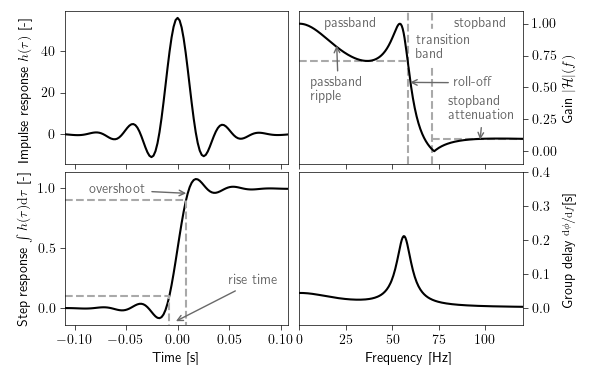

/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [55]:
'''
Example figure for step response(slow/fast, overshoot, phase) and frequency response (roll-off, ripple, attenuation)
'''

with matplotlib.rc_context(rc=print_context_dict):
    fig, axes = plt.subplots(2,2, sharex='col')
    (ax11,ax21,ax12,ax22) = axes.flat
    fs = 512
    N = 1024
    M = 111

    df=fs/N
    dur=1/df
    dt=dur/N

    freq = np.fft.fftshift(np.fft.fftfreq(N,dt))
    tim = np.linspace(-dur/2,dur/2-dt,N)
    # discrete time indexer
    n = np.linspace(-N//2,N//2-1,N)/2


    irf = np.sin(np.pi*n*(2*M+1)/N)/np.sin(np.pi*n/N) 
    irf[n==0] = (2*M+1)
    irf /= 4
    irf[(N-M)//2:-(N-M)//2] *= np.hamming(M)
    irf[:(N-M)//2]=0
    irf[-(N-M)//2:]=0

    # plot IRF, step response
    ax11.plot(tim,irf, color="k")
    ax12.plot(tim, scipy.integrate.cumtrapz(irf,dx=dt, initial=0), color="k")


    tolp=1-10**(-3/20)#0.1 #durchlassbereich
    tols=0.1#sperrbereich
    wpass=58.19*2*np.pi
    wstop=71.12*2*np.pi
    gpass = np.log10(1-tolp)*(-20)
    gstop = np.log10(tols)*(-20)


    #generate analog system
    sys = signal.iirdesign(wpass, wstop, 
                           gpass, gstop,
                           analog=True, ftype='ellip')
    #print(sys)
    sys = signal.lti(*sys)
    w,frf = sys.freqresp(w=freq*2*np.pi)
    w/=2*np.pi
    angle = np.unwrap(np.angle(frf))
    group_delay = -np.diff(angle,prepend=-angle[-1:])/df
    group_delay[group_delay<-6] +=2*np.pi

    # plot FRF, group delay
    ax21.plot(freq,np.abs(frf), color="k")
    ax22.plot(freq,group_delay, color="k")


    # plot beautification
    ax21.set_ylabel('Gain $|\\mathcal{H}| (f) $')
    ax21.yaxis.set_label_position("right")
    ax21.yaxis.tick_right()
    ax21.set_ylim((-0.1,1.1))

    ax22.set_ylabel('Group delay $\\sfrac{\\mathrm{d}\\phi}{\\mathrm{d}f}$[s]')
    ax22.yaxis.set_label_position("right")
    ax22.yaxis.tick_right()
    ax22.set_xlim((0,120))
    ax22.set_xlabel('Frequency [Hz]')
    ax22.set_ylim((-0.05,.4))

    ax11.set_ylabel('Impulse response $h(\\tau)$ [-]')

    ax12.set_ylabel('Step response $\\int h(\\tau) \mathrm{d} \\tau$ [-]')
    ax12.set_xlabel('Time [s]')
    ax12.set_xlim((tim[(N-M)//2],tim[-(N-M)//2]))
    ax12.set_ylim((-.14,1.14))

    fig.subplots_adjust(top=0.970,bottom=0.11,left=0.11, right=0.885, wspace=0.05,hspace=0.05)
    # fig.legend([h1]+nt_handles,['contin.', 'N=11', 'N=21', 'N=61'], loc=(0.72,0.75))
    fig.align_ylabels()
    fig.align_xlabels()

    plt.annotate("overshoot",(.32,.47),(.15,.47), xycoords='figure fraction', arrowprops={'arrowstyle':'->', "color":'dimgrey'}, color='dimgrey')
    ax12.plot([tim[(N-M)//2],-0.008,-0.008],[0.1,0.1,-0.142],ls='dashed', color='darkgrey')
    ax12.plot([tim[(N-M)//2],0.008,0.008],[0.9,0.9,-0.142],ls='dashed', color='darkgrey')
    ax12.annotate("rise time",(-0.004,-0.12),(0.05,0.2), xycoords='data', arrowprops={'arrowstyle':'->', "color":'dimgrey'}, color='dimgrey')

#     ax21.vlines(wpass/2/np.pi,-0.1,(1-tolp), color='darkgrey',ls='dashed')
#     ax21.vlines(wstop/2/np.pi, tols,1.1, color='darkgrey',ls='dashed')
    
    ax21.vlines(wpass/2/np.pi,-0.1,1.1, color='darkgrey',ls='dashed')
    ax21.vlines(wstop/2/np.pi, -0.1,1.1, color='darkgrey',ls='dashed')
    ax21.hlines(1-tolp,0,wpass/2/np.pi, color='darkgrey',ls='dashed')
    ax21.hlines(tols,wstop/2/np.pi,fs/2, color='darkgrey',ls='dashed')
    ax21.annotate("passband",(14,.97), color='dimgrey')
    ax21.annotate("stopband",(83,0.97), color='dimgrey')
    ax21.annotate("transition \n band",(62.5,0.73), color='dimgrey', backgroundcolor='#FFFFFF')
    ax21.annotate("roll-off",(58,.54),(83,.51), arrowprops={'arrowstyle':'->', "color":'dimgrey'}, color='dimgrey')
    ax21.annotate("passband \n ripple",(20,0.85),(6,.4), arrowprops={'arrowstyle':'->', "color":'dimgrey'}, color='dimgrey')
    ax21.annotate("stopband \n attenuation",(97,0.07),(80,0.25), arrowprops={'arrowstyle':'->', "color":'dimgrey'}, color='dimgrey')

#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter_characteristics.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter_characteristics.png')
    

<IPython.core.display.Javascript object>


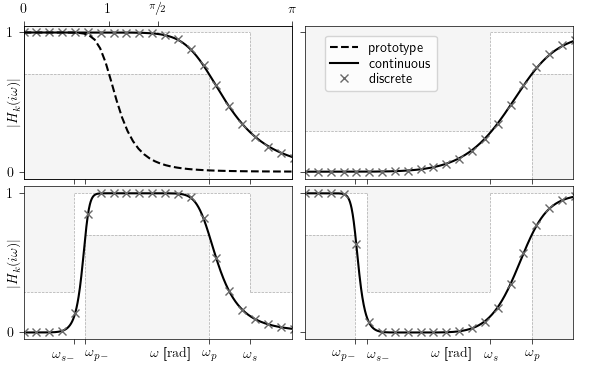

/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/scipy/signal/filter_design.py:188: RuntimeWarning: invalid value encountered in multiply
  s = 1j * w
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/lib/polynomial.py:736: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/scipy/signal/filter_design.py:189: RuntimeWarning: invalid value encountered in true_divide
  h = polyval(b, s) / polyval(a, s)
<string>:2: RuntimeWarning: divide by zero encountered in power
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/scipy/signal/fil

In [53]:
from scipy.signal.filter_design import buttap

H,C,K,w,dD,dS,wD,wS,n=symbols('H_K C K \\omega \\delta_D \\delta_S \\omega_D \\omega_S n')
_H=1/(1+C**2*abs(K)**2)

dwpass=58.19
dwstop=71.12

dwpassl=19.4
dwstopl=15.8

dws=512
order=6
tolpass = 0.7
tolstop = 0.29

gpass = np.log10(tolpass)*(-20)
gstop = np.log10(tolstop)*(-20)

dwmax=2*dwstop+-dwpass
omegas = np.linspace(0,dwmax,1000)
domegas = omegas/dws

with matplotlib.rc_context(rc=print_context_dict):
    fig,axes = plt.subplots(2,2, figsize=(5.906,5.906/1.618), sharex='col', sharey=True)
    (ax11,ax21,ax12,ax22) = axes.flat    

    proto=signal.filter_design.buttap(order)
    pw,proto=signal.freqs(*signal.zpk2tf(*proto), np.linspace(0,np.pi))
    axp=ax11.twiny()
    hp,=axp.plot(pw,np.abs(proto), color='k',ls='dashed')
    axp.set_xlim((0,np.pi))
    axp.set_xticks([0,1,np.pi/2,np.pi])
    axp.set_xticklabels(['$0$','$1$','$\sfrac{\pi}{2}$','$\pi$',])
    
    for i in range(4):
        ax=axes.flat[i]

        proto=signal.filter_design.buttap(order)
        if i==0:
            wp=w/wD # LP2LP
            butterpol=wp**n
            D1=sqrt(2*dD-dD**2)/(1-dD)
            D2=sqrt(1-dS**2)/dS
            butter=sqrt(_H.subs(K,butterpol).subs(C,D1).subs(n,order))
            fun=(butter.subs(dD,1-tolpass).subs(dS,tolstop).subs(wD,dwpass).subs(wS,dwstop))
            fun=lambdify(w,fun)
            system = signal.iirfilter(order,dwpass/dws,analog=False, ftype='butter',btype='lowpass')
#             system = signal.iirdesign(dwpass/dws,dwstop/dws,gpass,gstop,analog=False, ftype='butter')
            
            dwn = dwpass/dws
            dw0 = 2/1*np.tan(dwn/2)
            pw,proto=signal.freqs(*signal.zpk2tf(*proto), domegas/dw0)
        elif i==1:
            wp=wS/w # LP2HP
            butterpol=wp**n
            D1=sqrt(2*dD-dD**2)/(1-dD)
            D2=sqrt(1-dS**2)/dS
            butter=sqrt(_H.subs(K,butterpol).subs(C,D1).subs(n,order))
            fun=(butter.subs(dD,1-tolpass).subs(dS,tolstop).subs(wD,dwpass).subs(wS,dwstop))
            fun=lambdify(w,fun)
            
            
            system = signal.iirfilter(order,dwstop/dws,analog=False, ftype='butter',btype='highpass')
#             system = signal.iirdesign(dwstop/dws,dwpass/dws,gpass,gstop,analog=False, ftype='butter')
        
            dwn = dwstop/dws
            dw0 = 2/1*np.tan(dwn/2)
            pw,proto=signal.freqs(*signal.zpk2tf(*proto), dw0/(domegas))
        elif i==2:
            wp=(w**2-wD*wS)/(wS-wD)/w # LP2BP
            butterpol=wp**n
            D1=sqrt(2*dD-dD**2)/(1-dD)
            D2=sqrt(1-dS**2)/dS
            butter=sqrt(_H.subs(K,butterpol).subs(C,D1).subs(n,order))
            fun=(butter.subs(dD,1-tolpass).subs(dS,tolstop).subs(wD,dwpassl).subs(wS,dwpass))
            fun=lambdify(w,fun)
            system = signal.iirfilter(order,[dwpassl/(dws), dwpass/(dws)], analog=False, ftype='butter',btype='bandpass')
#             system = signal.iirdesign([dwpassl/dws,dwpass/dws],[dwstopl/dws,dwstop/dws],gpass,gstop,analog=False, ftype='butter')

            dw0 = 2/1*np.tan(dwpass/dws/2)
            dw0l = 2/1*np.tan(dwpassl/dws/2)
            pw,proto=signal.freqs(*signal.zpk2tf(*proto), (domegas**2-dw0*dw0l)/((dw0-dw0l)*domegas))
        else:
            wp=(wS-wD)*w/(w**2-wD*wS) # LP2BS
            butterpol=wp**n
            D1=sqrt(2*dD-dD**2)/(1-dD)
            D2=sqrt(1-dS**2)/dS
            butter=sqrt(_H.subs(K,butterpol).subs(C,D1).subs(n,order))
            fun=(butter.subs(dD,1-tolpass).subs(dS,tolstop).subs(wD,dwstopl).subs(wS,dwstop))
            fun=lambdify(w,fun)
            system = signal.iirfilter(order,[dwstopl/(dws), dwstop/(dws)], analog=False, ftype='butter',btype='bandstop')

            dw0 = 2/1*np.tan(dwstop/dws/2)
            dw0l = 2/1*np.tan(dwstopl/dws/2)
            pw,proto=signal.freqs(*signal.zpk2tf(*proto), ((dw0l-dw0)*domegas)/(domegas**2-dw0*dw0l))




        omegas_, h = signal.freqz(*system, worN=np.linspace(0,np.pi,128))
        omegas_*=dws/np.pi


        hc,=ax.plot(omegas,fun(omegas),color='k')
        hd,=ax.plot(omegas_,np.abs(h),ls='none',marker='x',color='dimgrey')
#         hc,=ax.plot(omegas,np.abs(proto), color='k')
        
        ax.set_xlim((0,dwmax))
        

    ymin,ymax=ax.get_ylim()
    ax11.hlines(tolpass,0,dwpass, color='darkgrey',ls='dashed',lw=0.5)
    ax11.hlines(tolstop,dwstop,dwmax, color='darkgrey',ls='dashed',lw=0.5)
    ax11.hlines(1,0,dwstop, color='darkgrey',ls='dashed',lw=0.5)    
    ax11.vlines(dwpass,ymin,tolpass, color='darkgrey',ls='dashed',lw=0.5)
    ax11.vlines(dwstop,tolstop,1, color='darkgrey',ls='dashed',lw=0.5)
    ax11.fill((0,dwpass,dwpass,0),(ymin,ymin,tolpass,tolpass), 'whitesmoke')
    ax11.fill((0,0,dwmax,dwmax,dwstop,dwstop),(1,ymax,ymax,tolstop,tolstop,1), 'whitesmoke')
    ax12.set_yticks([0,1])
    ax11.set_ylabel('$|H_k(i\\omega)|$',labelpad=-10)
    ax11.set_ylim((ymin,ymax))
    
    ax21.hlines(tolpass,dwstop,dwmax, color='darkgrey',ls='dashed',lw=0.5)
    ax21.hlines(tolstop,0,dwpass, color='darkgrey',ls='dashed',lw=0.5)
    ax21.hlines(1,dwpass,dwmax, color='darkgrey',ls='dashed',lw=0.5)    
    ax21.vlines(dwpass,tolstop,1, color='darkgrey',ls='dashed',lw=0.5)
    ax21.vlines(dwstop,ymin,tolpass, color='darkgrey',ls='dashed',lw=0.5)
    ax21.fill((0,dwpass,dwpass,dwmax,dwmax,0),(tolstop,tolstop,1,1,ymax,ymax), 'whitesmoke')
    ax21.fill((dwmax,dwmax,dwstop,dwstop),(ymin,tolpass,tolpass,ymin), 'whitesmoke')
    
    ax12.hlines(tolstop,ymin,dwstopl, color='darkgrey',ls='dashed',lw=0.5)
    ax12.vlines(dwstopl,tolstop,1, color='darkgrey',ls='dashed',lw=0.5)
    ax12.hlines(1,dwstopl,dwstop, color='darkgrey',ls='dashed',lw=0.5)
    ax12.vlines(dwstop,tolstop,1, color='darkgrey',ls='dashed',lw=0.5)
    ax12.hlines(tolstop,dwstop,dwmax, color='darkgrey',ls='dashed',lw=0.5)
    ax12.vlines(dwpassl,ymin,tolpass, color='darkgrey',ls='dashed',lw=0.5)
    ax12.hlines(tolpass,dwpassl,dwpass, color='darkgrey',ls='dashed',lw=0.5)
    ax12.vlines(dwpass,ymin,tolpass, color='darkgrey',ls='dashed',lw=0.5)
    ax12.fill([0,dwstopl,dwstopl,dwstop,dwstop,dwmax,dwmax,0],[tolstop,tolstop,1,1,tolstop,tolstop,ymax,ymax], 'whitesmoke')
    ax12.fill([dwpassl,dwpassl,dwpass,dwpass],[ymin,tolpass,tolpass,ymin], 'whitesmoke')
    ax12.set_ylabel('$|H_k(i\\omega)|$',labelpad=-10)
    ax12.set_yticks([0,1])
    ax12.set_xticks([dwstopl,dwpassl,dwpass,dwstop])
    labels=ax12.set_xticklabels(['$\omega_{s-}$','$\omega_{p-}$','$\omega_{p}$','$\omega_{s}$',])
    labels[0].set_horizontalalignment('right')
    labels[1].set_horizontalalignment('left')
    ax12.set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.55)
    
    ax22.hlines(tolpass,0,dwstopl, color='darkgrey',ls='dashed',lw=0.5)
    ax22.vlines(dwstopl,ymin,tolpass, color='darkgrey',ls='dashed',lw=0.5)
    ax22.hlines(tolpass,dwstop,dwmax, color='darkgrey',ls='dashed',lw=0.5)
    ax22.vlines(dwstop,ymin,tolpass, color='darkgrey',ls='dashed',lw=0.5)
    ax22.hlines(1,0,dwpassl, color='darkgrey',ls='dashed',lw=0.5)    
    ax22.vlines(dwpassl,1,tolstop, color='darkgrey',ls='dashed',lw=0.5)    
    ax22.hlines(tolstop,dwpassl,dwpass, color='darkgrey',ls='dashed',lw=0.5)    
    ax22.vlines(dwpass,1,tolstop, color='darkgrey',ls='dashed',lw=0.5)    
    ax22.hlines(1,dwpass,dwmax, color='darkgrey',ls='dashed',lw=0.5)    
    ax22.fill([0,dwstopl,dwstopl,0],[ymin,ymin,tolpass,tolpass], 'whitesmoke')
    ax22.fill([dwstop,dwmax,dwmax,dwstop],[ymin,ymin,tolpass,tolpass], 'whitesmoke')
    ax22.fill([0,dwpassl,dwpassl,dwpass,dwpass,dwmax,dwmax,0],[1,1,tolstop,tolstop,1,1,ymax,ymax],'whitesmoke')
    ax22.set_xticks([dwstopl,dwpassl,dwpass,dwstop])
    labels=ax22.set_xticklabels(['$\omega_{p-}$','$\omega_{s-}$','$\omega_{s}$','$\omega_{p}$',])
    labels[0].set_horizontalalignment('right')
    labels[1].set_horizontalalignment('left')
    ax22.set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.55)
    
    fig.legend(handles=[hp,hc,hd],labels=['prototype','continuous', 'discrete'], loc=(0.55,0.75))
    
    fig.subplots_adjust(top=0.930,bottom=0.07,left=0.04, right=0.970, wspace=0.05,hspace=0.05)
    
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter_transformation.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter_transformation.png')    


### Windowed Sinc / Brickwall filter

<IPython.core.display.Javascript object>


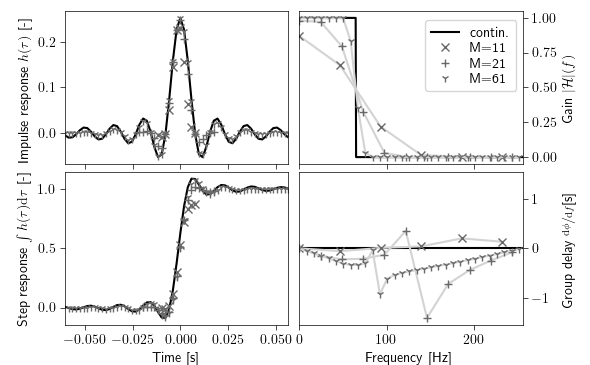

low pass


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


In [60]:
%matplotlib notebook
with matplotlib.rc_context(rc=print_context_dict):
    # plot impulse response, frequency response, step response and phase response / group delay
    fig, axes = plt.subplots(2,2, sharex='col')
    (ax11,ax21,ax12,ax22) = axes.flat

    #https://flylib.com/books/en/2.729.1/the_dft_of_rectangular_functions.html
    #windowed-sinc aka. Dirichlet-Kernel

    # input parameters
    fs=512
    N=1024
    df=fs/N
    dur=1/df
    dt=dur/N

    freq = np.fft.fftfreq(N,dt)
    tim = np.linspace(-dur/2,dur/2-dt,N)
    # discrete time indexer
    n = np.linspace(-N//2,N//2-1,N)

    # cut off frequencies
    fcl=64.65
    fch=None

    # validate cut off frequencies
    # build fir frequency response
    if fcl is not None:
        print("low pass")
        fcl=np.round(fcl/df)*df
        frfl = np.zeros((N,))
        Kl=int(fcl/df)
        frfl[:Kl+1] = 1 # including sample K
        frfl[-Kl:] = 1
    if fch is not None:
        print("high pass")
        fch=np.round(fch/df)*df
        frfh = np.zeros((N,))
        Kh=int(fch/df)
        frfh[Kh:-Kh+1] = 1
    if fcl is not None and fch is not None:
        if fcl < fch:
            print('band reject')
            frf = frfh+frfl
        if fcl> fch: 
            print('band pass')
            frf = frfh*frfl
    elif fch is not None: frf=frfh
    elif fcl is not None: frf=frfl

    # group delay / phase response
    angle = np.angle(frf)
    angle[angle>np.pi/2]-=np.pi
    angle[angle<-np.pi/2]+=np.pi
    group_delay = -np.diff(angle,prepend=[0])/df


    # plot given frequency response and group delay
    ax21.plot(np.fft.fftshift(freq),np.fft.fftshift(np.abs(frf)),color='k')
    ax22.plot(np.fft.fftshift(freq),np.fft.fftshift(group_delay),color='k')


    # compute IRF
    irf = np.fft.ifft(frf)
    if (np.imag(irf)>1e-16).any():print('Warning: complex IRF')
    irf = np.real(irf)

    # make IRF symmetric around 0 for convolution
    irf=np.roll(irf, N//2)



    # Theoretical IRF
    # Dirichlet Kernel aka aliased sinc function 
    if fcl is not None:
        irf2l = 1/N*np.sin(np.pi*n*(2*Kl+1)/N)/np.sin(np.pi*n/N) # Number of 1s in the frf is 2*K+1 [-K...0...K]
        irf2l[n==0]=(2*Kl+1)/N # l'Hospital of sin((2k+1)t)/sin(t)
    if fch is not None:
        #using spectral reversal
        Kh=(fs/2-fch)/df
        irf2h = 1/N*np.sin(np.pi*n*(2*Kh+1)/N)/np.sin(np.pi*n/N) # Number of 1s in the frf is 2*K+1 [-K...0...K]
        irf2h[n==0]=(2*Kh+1)/N # l'Hospital of sin((2k+1)t)/sin(t)
        irf2h[1::2]*=-1
    if fcl is not None and fch is not None:
        if fcl < fch:# band reject
            irf2 = irf2h+irf2l
        if fcl> fch: # band pass
            irf2 = np.convolve(irf2h,irf2l)
            nN=irf2.shape[0]
            irf2=irf2[(nN-N)//2:-(nN-N)//2] # truncate excessive length due to convolution
    elif fch is not None:
        irf2=irf2h
    elif fcl is not None:
        irf2=irf2l

    h1,=ax11.plot(tim,irf2,color='k')
    ax12.plot(tim, np.cumsum(irf2),color='k')
    nt_handles=[]

    for numtapps,marker in zip([11,21,61,],['x','+','1']):
        # truncate and apply window
        N_trunc = N-numtapps
        irf_trunc = irf[N_trunc//2:-N_trunc//2]*np.hamming(numtapps)
        tim_trunc = tim[N_trunc//2:-N_trunc//2]

        # plot discrete IRF
        ax11.plot(tim_trunc,irf_trunc, marker=marker,ls='none',color='dimgrey')
    #     ax12.plot(tim_trunc,np.cumsum(irf_trunc), marker=marker,ls='none',color='dimgrey')
        ax12.plot(tim_trunc[1:],scipy.integrate.cumtrapz(irf_trunc), marker=marker,ls='none',color='dimgrey')
    #     ax11.plot(tim_trunc,irf_trunc,color='lightgrey')
    #     ax12.plot(tim_trunc,np.cumsum(irf_trunc),color='lightgrey')

        dur_trunc = tim_trunc[-1]-tim_trunc[0]
        df_trunc = 1/dur_trunc
        frf_trunc = np.fft.fft(irf_trunc)

        # plot truncated and windowed frf
        freq_trunc = np.fft.fftfreq(irf_trunc.shape[0], dt)
        angle = np.fft.fftshift(np.angle(frf_trunc))
        angle[angle<-np.pi/2]+=np.pi
        angle[angle>=np.pi/2]-=np.pi
#         angle=np.unwrap(angle)
        group_delay = -np.diff(angle,prepend=angle[-1:])#/df_trunc

        ax21.plot(np.fft.fftshift(freq_trunc),np.fft.fftshift(np.abs(frf_trunc)),color='lightgrey')

        ax22.plot(np.fft.fftshift(freq_trunc),angle,color='lightgrey')

        ax21.plot(np.fft.fftshift(freq_trunc),np.fft.fftshift(np.abs(frf_trunc)), marker=marker,ls='none',color='dimgrey')
        h,=ax22.plot(np.fft.fftshift(freq_trunc),angle, marker=marker,ls='none',color='dimgrey')
        nt_handles.append(h)    
    # plot beautification
    ax21.set_ylabel('Gain $|\\mathcal{H}| (f) $')
    ax21.yaxis.set_label_position("right")
    ax21.yaxis.tick_right()

    ax22.set_ylabel('Group delay $\\sfrac{\\mathrm{d}\\phi}{\\mathrm{d}f}$[s]')
#     ax22.set_yticks((-0.04,0,0.04,0.08,0.12))
    ax22.yaxis.set_label_position("right")
    ax22.yaxis.tick_right()
    ax22.set_xlim((0,fs/2))
    ax22.set_xlabel('Frequency [Hz]')

    ax11.set_ylabel('Impulse response $h(\\tau)$ [-]')

    ax12.set_ylabel('Step response $\\int h(\\tau) \mathrm{d} \\tau$ [-]')
    ax12.set_xlabel('Time [s]')
    ax12.set_xlim((tim_trunc[0],tim_trunc[-1]))
    fig.subplots_adjust(top=0.970,bottom=0.11,left=0.11, right=0.885, wspace=0.05,hspace=0.05)
    fig.legend([h1]+nt_handles,['contin.', 'M=11', 'M=21', 'M=61'], loc=(0.72,0.75))
    fig.align_ylabels()
    fig.align_xlabels()
    

#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/brickwall.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/brickwall.png')
    
    plt.show()

#### Application to example structure ambient response

<IPython.core.display.Javascript object>


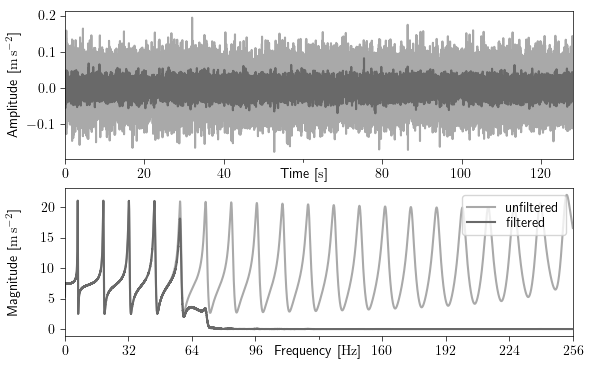

In [13]:
# system generation
N=2**16
rho = 7850
A = 0.0343
L = 200
m = rho*A*L
modmass = m/2
omegas,frf = system_frf(N,fs/2,L,2.1e11,rho,A,0.01)

# system input (white noise)
phase=np.linspace(0,np.pi,N//2+1)
phase=(np.random.rand(N//2+1)-0.5)
Pomega = 10000*np.ones_like(frf)*np.exp(1j*phase*2*np.pi)/modmass

# time domain signal (system output = filter input)
sig=np.fft.irfft(frf*Pomega)

df = (omegas[1]-omegas[0])/2/np.pi
dt = 1/df/N
t = np.linspace(0,(N-1)*dt,N)
with matplotlib.rc_context(rc=print_context_dict):
    fig, (ax31,ax32)=plt.subplots(2,1,)
    h1,=ax31.plot(t,sig, color='darkgrey',label='unfiltered')
    ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig))), color='darkgrey')

    sig_filt = np.convolve(sig, irf_trunc)
    nN=irf_trunc.shape[0]-1
    sig_filt=sig_filt[nN//2+1:-nN//2+1] # truncate excessive length due to convolution

    h2,=ax31.plot(t,sig_filt,color='dimgrey',label='filtered')
    ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig_filt.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig_filt))), color='dimgrey')
    ax32.set_xlim(xmin=0,xmax=fs/2)
    ax31.set_xlim(xmin=0,xmax=t.max())
    ax31.set_ylabel("Amplitude [\\si{\\metre\\per\\second\\squared}]")
    ax31.set_xlabel("Time [\\si{\\second}]",labelpad=-9,backgroundcolor='white',x=0.47)
    ax32.set_ylabel("Magnitude [\\si{\\metre\\per\\second\\squared}]")
    ax32.set_xlabel("Frequency [\\si{\\hertz}]",labelpad=-9,backgroundcolor='white')
    ax32.xaxis.set_major_locator(plt.MultipleLocator(32))
    fig.subplots_adjust(top=0.970,bottom=0.08,left=0.11, right=0.97, wspace=0.2,hspace=0.2)
    ax32.legend(handles=[h1,h2],loc='upper right')
    fig.align_ylabels()
    
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/brickwall_example.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/brickwall_example.png')

#### Moving Average Filter

<IPython.core.display.Javascript object>


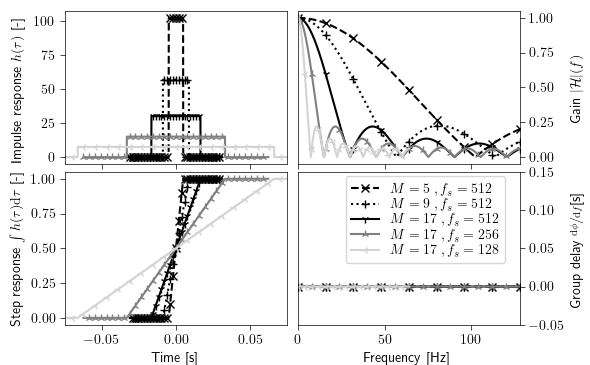

7


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel

In [66]:
%matplotlib notebook

with matplotlib.rc_context(rc=print_context_dict):
    # plot impulse response, frequency response, step response and phase response / group delay
    fig, axes = plt.subplots(2,2, sharex='col')
    (ax11,ax21,ax12,ax22) = axes.flat
    leg_handles = []

    #https://flylib.com/books/en/2.729.1/the_dft_of_rectangular_functions.html
    #windowed-sinc aka. Dirichlet-Kernel

    # input parameters
    fs=512
    N=32
    lenf=6*dt

    M=int(np.around(lenf/dt/2)*2+1)
    if M<=1: print('filter kernel too short')
    lenf=M*dt
    print(M)

    for M,fs,marker,ls,color in zip([5,9,17,17,17],
                                    [512,512,512,256,128],
                                    ['x','+','1','2','3'],
                                    ['dashed','dotted','solid','solid','solid'],
                                    ['black','black','black','grey','lightgrey']):
    #     if M>=N: print('filter kernel too long')
        df=fs/N
        dur=1/df
        dt=1/fs
        lenf=M*dt

    #     if N==32:
        # generate and plot theoretical results
        N_=8192
        fs_=N_*df
        dt_=1/fs_
        freq_ = np.fft.fftfreq(N_,dt)
        tim_ = np.linspace(-dur/2,dur/2-dt_,N_)
        # discrete frequency indexer
        m_ = np.fft.ifftshift(np.linspace(-N//2,N//2-N/N_,N_))
        M_=int(np.around(lenf/dt_/2)*2+1)

        # build IRF
        irf_ = np.zeros((N_,))
        irf_[:M_//2] = 1 # including sample M
        irf_[-M_//2:] = 1
        irf_=np.roll(irf_, N_//2+1)/lenf
        frf2_ = np.exp((1j*2*np.pi*m_/N)*((M//2)-(M-1)/2))*np.sin(np.pi*m_*M/N)/np.sin(np.pi*m_/N)
        frf2_[m_==0] = 1*M
        frf2_ *=dt/lenf
        angle_ = np.fft.fftshift(np.angle(frf2_))
        angle_[angle_>=np.pi/2]-=np.pi
        angle_[angle_<-np.pi/2]+=np.pi
        group_delay_ = -np.diff(angle_,prepend=-angle_[-1:])/df

        # plot IRF, step response, FRF and group delay
        ax11.plot(tim_,irf_,color=color,ls=ls)
    #     ax12.plot(tim_, np.cumsum(irf_)*dt_,color=color,ls=ls)
        ax12.plot(tim_[1:], scipy.integrate.cumtrapz(irf_,dx=dt_),color=color,ls=ls)
        ax21.plot(np.fft.fftshift(freq_),np.fft.fftshift(np.abs(frf2_)),color=color,ls=ls)
        ax22.plot(np.fft.fftshift(freq_),group_delay_,color=color,ls=ls)



        # generate discrete IRF
        freq = np.fft.fftfreq(N,dt)
        tim = np.linspace(-dur/2,dur/2-dt,N)
        # discrete frequency indexer
        m = np.fft.ifftshift(np.linspace(-N//2,N//2-1,N))

        # build IRF
        irf = np.zeros((N,))
        irf[:M//2+1] = 1
        irf[-M//2+1:] = 1
        if not M==np.sum(irf):
            print(f'M {M} is not sum(irf) {np.sum(irf)}')

        # make IRF symmetric around 0 for convolution
        irf=np.roll(irf, N//2+1)/lenf

        # start=tim[:N//2][irf[:N//2]==0][-1] # time instant where impulse starts to rise (i.e. it is just still 0)
        # end=tim[irf==1][-1] # time instant where impulse starts to descent (i.e. it is just still 1)

        # compute FRF and group delay
        frf = np.fft.fft(np.roll(irf,-N//2-1))*dt
        angle = np.fft.fftshift(np.angle(frf))
        angle[angle>=np.pi/2]-=np.pi
        angle[angle<-np.pi/2]+=np.pi
        group_delay = -np.diff(angle,prepend=-angle[-1:])/df

        # plot given IRF and step response
        # h1,=ax11.plot(tim,irf,color='k',ls='none',marker='+')
        # ax12.plot(tim, np.cumsum(irf)*dt,color='k',ls='none',marker='+')
        # plot computed frequency response and group delay
        ax21.plot(np.fft.fftshift(freq),np.fft.fftshift(np.abs(frf)),color=color, ls='none', marker=marker)
        ax22.plot(np.fft.fftshift(freq),group_delay,color=color, ls='none',marker=marker)


        # # Theoretical FRF
        # # Dirichlet Kernel aka aliased sinc function 
    #     omegas = freq*2*np.pi
        frf2 = np.exp((1j*2*np.pi*m/N)*((M//2)-(M-1)/2))*np.sin(np.pi*m*M/N)/np.sin(np.pi*m/N)
        frf2[m==0]=(2*M)/2
        frf2*=dt/lenf
        angle2 = np.angle(frf2)
        angle2[angle2>=np.pi/2]-=np.pi
        angle2[angle2<-np.pi/2]+=np.pi
        group_delay2 = -np.diff(angle2,prepend=[0])/df

        irf2 = np.fft.ifftshift(np.fft.ifft(frf2/dt)).real

        # plot computed IRF and step response
        ax11.plot(tim,irf2,color=color,ls='none',marker=marker)
    #     ax12.plot(tim, np.cumsum(irf2)*dt,color=color,ls='none',marker=marker)
        ax12.plot(tim[1:], scipy.integrate.cumtrapz(irf2,dx=dt),color=color,ls='none',marker=marker)
        # plot given frequency response and group delay
        # ax21.plot(np.fft.fftshift(freq),np.fft.fftshift(np.abs(frf2)),color='k', ls='none', marker='+')
        # ax22.plot(np.fft.fftshift(freq),np.fft.fftshift(group_delay2),color='k', ls='none',marker='+')

        # generate legend handles
        label=f'$\\tau = {M*dt*1000:.2f} \;, f_s = {fs}$'
        if fs<512:
            label=f'$\\tau = {M*dt*1000:.1f} \;, f_s = {fs}$'
        if M==4:
            label=f'$\\tau = {M*dt*1000:.3f} \;, f_s = {fs}$'
        label=f'$M = {M} \;, f_s = {fs}$'
        line = matplotlib.lines.Line2D([], [], color=color, marker=marker, ls=ls, label=label)
        leg_handles.append(line)

    # plot beautification
    ax21.set_ylabel('Gain $|\\mathcal{H}| (f) $')
    ax21.yaxis.set_label_position("right")
    ax21.yaxis.tick_right()

    ax22.set_ylabel('Group delay $\\sfrac{\\mathrm{d}\\phi}{\\mathrm{d}f}$[s]')
    ax22.set_ylim((-0.05,0.15))
    ax22.yaxis.set_label_position("right")
    ax22.yaxis.tick_right()
    ax22.set_xlim((0,128))
    ax22.set_xlabel('Frequency [Hz]')

    ax11.set_ylabel('Impulse response $h(\\tau)$ [-]')

    ax12.set_ylabel('Step response $\\int h(\\tau) \mathrm{d} \\tau$ [-]')
    ax12.set_xlabel('Time [s]')
    ax12.set_xlim((-0.075,0.075))

    fig.subplots_adjust(top=0.970,bottom=0.11,left=0.11, right=0.88, wspace=0.05,hspace=0.05)
    fig.legend(handles=leg_handles, loc=(0.585,0.28))
    fig.align_ylabels()
    fig.align_xlabels()
    
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/moving_average.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/moving_average.png')
    plt.show()

0.021484375


<IPython.core.display.Javascript object>


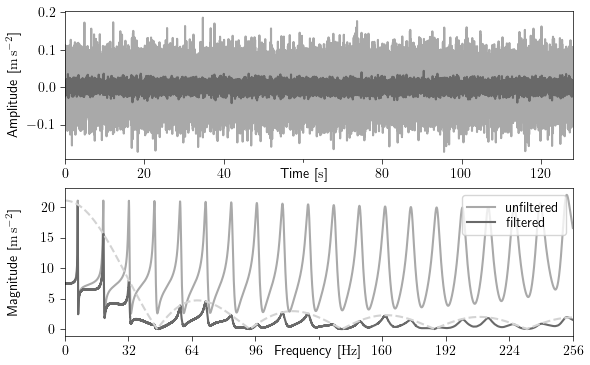

/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [15]:
# system generation
N=2**16
fs=512
df=fs/N
dur=1/df
dt=1/fs
lenf=M*dt
M=11
lenf=M*dt
print(lenf)

rho = 7850
A = 0.0343
L = 200
m = rho*A*L
modmass = m/2
omegas,frf = system_frf(N,fs/2,L,2.1e11,rho,A,0.01)

# system input (white noise)
phase=np.linspace(0,np.pi,N//2+1)
phase=(np.random.rand(N//2+1)-0.5)
Pomega = 10000*np.ones_like(frf)*np.exp(1j*phase*2*np.pi)/modmass

# time domain signal (system output = filter input)
sig=np.fft.irfft(frf*Pomega)

df = (omegas[1]-omegas[0])/2/np.pi
dt = 1/df/N
t = np.linspace(0,(N-1)*dt,N)
with matplotlib.rc_context(rc=print_context_dict):
    fig, (ax31,ax32)=plt.subplots(2,1,)

    h1,=ax31.plot(t,sig, color='darkgrey',label='unfiltered')
    ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig))), color='darkgrey')

    sig_filt = np.convolve(sig, np.ones(M)/M)
    nN=M-1
    sig_filt=sig_filt[nN//2+1:-nN//2+1] # truncate excessive length due to convolution

    h2,=ax31.plot(t,sig_filt,color='dimgrey',label='filtered')
    ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig_filt.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig_filt))), color='dimgrey')

    m = np.fft.ifftshift(np.linspace(-N//2,N//2-1,N))
    frf2 = np.exp((1j*2*np.pi*m/N)*((M//2)-(M-1)/2))*np.sin(np.pi*m*M/N)/np.sin(np.pi*m/N)
    frf2[m==0]=(2*M)/2
    frf2*=dt/lenf
    ax32.plot(np.fft.fftshift(np.fft.fftfreq(frf2.shape[0],dt)),np.fft.fftshift(np.abs(frf2))*21.06,color='lightgrey', ls='dashed')


    ax32.set_xlim(xmin=0,xmax=fs/2)
    ax31.set_xlim(xmin=0,xmax=t.max())
    ax31.set_ylabel("Amplitude [\\si{\\metre\\per\\second\\squared}]")
    ax31.set_xlabel("Time [\\si{\\second}]",labelpad=-9,backgroundcolor='white',x=0.47)
    ax32.set_ylabel("Magnitude [\\si{\\metre\\per\\second\\squared}]")
    ax32.set_xlabel("Frequency [\\si{\\hertz}]",labelpad=-9,backgroundcolor='white')
    ax32.xaxis.set_major_locator(plt.MultipleLocator(32))
    fig.subplots_adjust(top=0.970,bottom=0.08,left=0.11, right=0.97, wspace=0.2,hspace=0.2)
    ax32.legend(handles=[h1,h2],loc='upper right')
    fig.align_ylabels()
    
    
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/moving_average_example.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/moving_average_example.png')

<IPython.core.display.Javascript object>


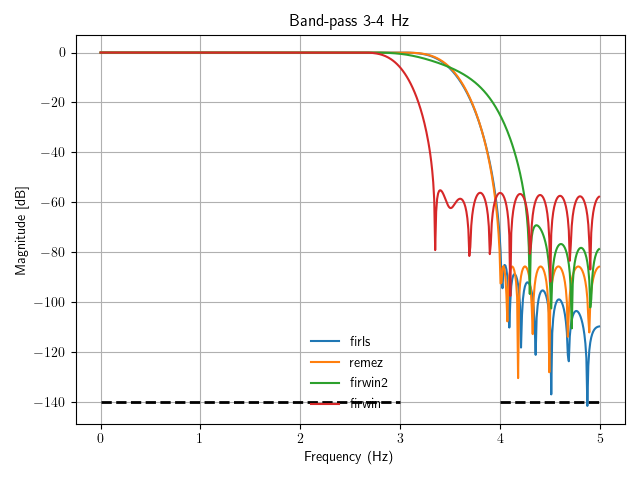

In [16]:
%matplotlib notebook
reload(plt)
%matplotlib notebook
%matplotlib notebook
fig, ax = plt.subplots()
fs = 10.0  # Hz
desired = (1, 1, 0, 0)
bands = (0, 3, 4, 5)
fir_firls = signal.firls(51, bands, desired, fs=fs)
fir_remez = signal.remez(51, bands, desired[::2], fs=fs)
fir_firwin2 = signal.firwin2(51, bands, desired, fs=fs)
fir_firwin = signal.firwin(numtaps=51, cutoff=3,fs=fs)
hs = list()
for fir in (fir_firls, fir_remez, fir_firwin2, fir_firwin):
    freq, response = signal.freqz(fir)
    hs.append(ax.plot(0.5*fs*freq/np.pi, 20*np.log10(np.abs(response)))[0])
for band, gains in zip(zip(bands[::2], bands[1::2]),
                       zip(desired[::2], desired[1::2])):
    ax.plot(band, 2*[20*(-7)], 'k--', linewidth=2)

ax.legend(hs, ('firls', 'remez', 'firwin2', 'firwin'),
          loc='lower center', frameon=False)

ax.set_xlabel('Frequency (Hz)')
ax.grid(True)
ax.set(title='Band-pass %d-%d Hz' % bands[1:3], ylabel='Magnitude [dB]')

fig.tight_layout()
plt.show()

#### Tolerance scheme and flipped version

<IPython.core.display.Javascript object>


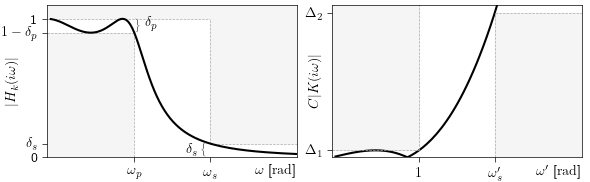

In [17]:


wp = 2.5
ws = 4.67481445
dP=0.1
dS=0.1

gpass = np.log10(1-dP)*(-20)
gstop = np.log10(dS)*(-20)

D1=np.sqrt(2*dP-dP**2)/(1-dP)
D2=np.sqrt(1-dS**2)/dS

system1 = signal.iirdesign(wp, ws, gpass, gstop,analog=True, ftype='cheby1')
system2 = signal.iirdesign(wp, ws, gpass, gstop,analog=True, ftype='cheby2')


fmax=ws+wp
with matplotlib.rc_context(rc=print_context_dict):
    fig,axes = plt.subplots(1,2, figsize=(5.906,5.906/1.618/2), sharex=False)
    
    #for system in (system1,system2):
    system=system1
    w, h = signal.freqs(*system)
    CKjw=np.sqrt(1/abs(h)**2-1)
    
    ymax=1.1
    ax1=axes[0]
    ax1.plot(w, abs(h), 'k')
    
    ax1.hlines(1-dP,0,wp, color='darkgrey',ls='dashed',lw=0.5)
    ax1.hlines(dS,ws,fmax, color='darkgrey',ls='dashed',lw=0.5)
    ax1.hlines(1,0,ws, color='darkgrey',ls='dashed',lw=0.5)    
    ax1.vlines(wp,0,1-dP, color='darkgrey',ls='dashed',lw=0.5)
    ax1.vlines(ws,dS,1, color='darkgrey',ls='dashed',lw=0.5)
    
    ax1.fill((0,wp,wp,0),(0,0,1-dP,1-dP), 'whitesmoke')
    ax1.fill((0,0,fmax,fmax,ws,ws),(1,ymax,ymax,dS,dS,1), 'whitesmoke')
    
    ax1.set_ylabel('$|H_k(i\\omega)|$',labelpad=-12)
    ax1.set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-11,loc='right')
    ax1.grid()
    ax1.set_xticks([wp,ws])
    ax1.set_xticklabels(['$\\omega_p$','$\\omega_s$'])

    ax1.set_yticks([0,dS,1-dP,1])
    ax1.set_yticklabels([0,'$\\delta_s$','$1-\\delta_p$',1])
    ax1.grid(0)
    ax1.set_ylim([0,ymax])
    ax1.annotate(r"$\}$",fontsize=10,xy=(wp, 0.925),color='dimgrey')
    ax1.annotate('$\\delta_p$',(wp+.3,0.94))

    ax1.annotate(r"$\{$",fontsize=10,xy=(ws-.3, 0.025),color='dimgrey')
    ax1.annotate('$\\delta_s$',(ws-.7,0.025))

    ax2=axes[1]    
    ax2.plot(w,CKjw, color='k')

    ymax=10.5
    ax2.axhline(D1,0,wp/fmax, color='darkgrey',ls='dashed',lw=0.5)
    ax2.axhline(D2,ws/fmax,1, color='darkgrey',ls='dashed',lw=0.5)
    ax2.axvline(wp,D1/ymax,1, color='darkgrey',ls='dashed',lw=0.5)
    ax2.axvline(ws,0,D2/ymax, color='darkgrey',ls='dashed',lw=0.5)
    
    ax2.fill((0,0,wp,wp),(D1,ymax,ymax,D1),color='whitesmoke')
    ax2.fill((ws,ws,fmax,fmax),(0,D2,D2,0),color='whitesmoke')

    ax2.set_ylabel('$C|K(i\\omega)|$',labelpad=-12)
    ax2.set_xlabel("$\\omega'$ [\\si{\\radian}]",labelpad=-11,loc='right')
    ax2.set_xticks([wp,ws])
    ax2.set_xticklabels(['$1$',"$\\omega'_s$"])
    ax2.set_yticks([D1,D2])
    ax2.set_yticklabels(['$\\Delta_1$',"$\\Delta_2$"])
    ax2.grid(0)
    ax2.set_ylim([0,ymax])

    ax2.set_xlim((0,fmax))
    ax1.set_xlim((0,fmax))
    fig.subplots_adjust(top=0.970,bottom=0.135,left=0.08, right=0.985, wspace=0.14,hspace=0.2)

    #fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter_specification.pdf')
    #fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter_specification.png')

### Butterworth filter: analytic and using scipy.signal

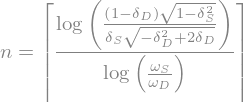

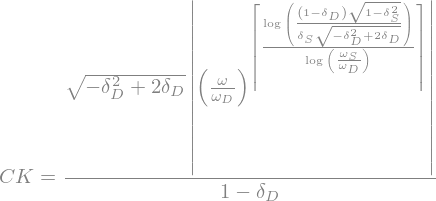

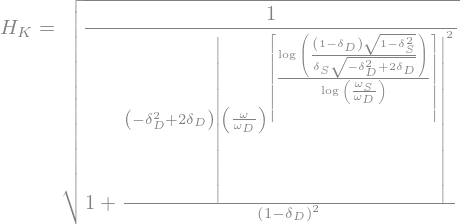

<IPython.core.display.Javascript object>


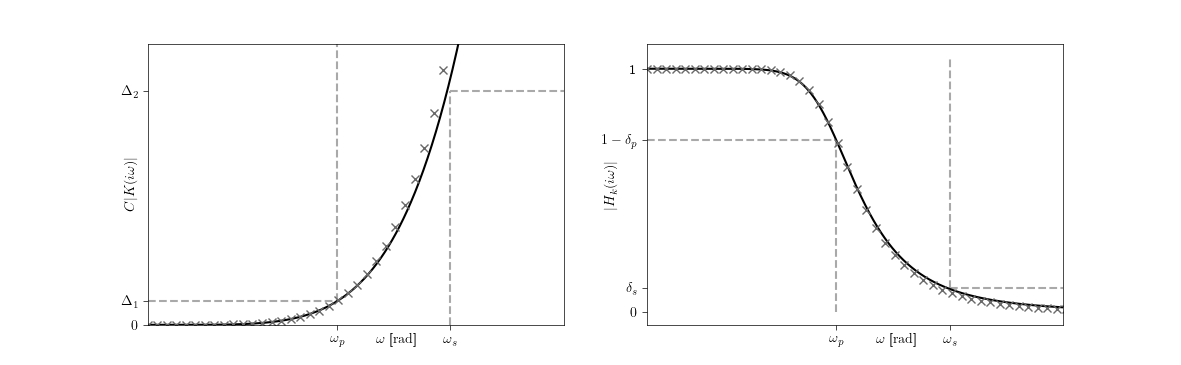

In [18]:
H,C,K,w,dD,dS,wD,wS,n=symbols('H_K C K \\omega \\delta_D \\delta_S \\omega_D \\omega_S n')
_H=1/(1+C**2*abs(K)**2)
wp=w/wD
wps=wS/wD

butterpol=wp**n

D1=sqrt(2*dD-dD**2)/(1-dD)
D2=sqrt(1-dS**2)/dS
n_=log(D2/D1,10)/log(wps,10) # convert to integer, even order not necessary
n_=ceiling(n_)
butter=sqrt(_H.subs(K,butterpol).subs(C,D1).subs(n,n_))

display(Eq(symbols('n'),n_))
display(Eq(C*K,D1*abs(butterpol.subs(n,n_))))
display(Eq(H,butter))



tolpass=1-10**(-3/20)#0.1 #durchlassbereich
tolstop=0.1#sperrbereich
dwpass=20*2*np.pi
dwstop=32*2*np.pi
gpass = np.log10(1-tolpass)*(-20)
gstop = np.log10(tolstop)*(-20)

fun=(D1*abs(butterpol.subs(n,n_))).subs(dD,tolpass).subs(dS,tolstop).subs(wD,dwpass).subs(wS,dwstop)
fun=lambdify(w,fun)
dwmax=2*dwstop+-dwpass
dws=128*2*np.pi
omegas = np.linspace(0,dwmax,1000)

system = signal.iirdesign(dwpass/(dws), dwstop/(dws), gpass, gstop,analog=False, ftype='butter')
omegas_, h = signal.freqz(*system, worN=np.linspace(0,np.pi,128))
omegas_*=dws/np.pi

with matplotlib.rc_context(rc=print_context_dict):
    fig,axes = plt.subplots(1,2, figsize=(5.906*2,5.906/1.618))
    axes[0].plot(omegas,fun(omegas),color='k')
    axes[0].plot(omegas_,np.sqrt(1/np.abs(h)**2-1),ls='none',marker='x',color='dimgrey')
    thisD1=float(D1.subs(dD,tolpass).subs(dS,tolstop).subs(wD,dwpass).subs(wS,dwstop))
    thisD2=float(D2.subs(dD,tolpass).subs(dS,tolstop).subs(wD,dwpass).subs(wS,dwstop))
    ymax=1.2*thisD2
    axes[0].set_ylim((0,ymax))
    axes[0].vlines(dwpass,thisD1,ymax, color='darkgrey',ls='dashed')
    axes[0].vlines(dwstop,0,thisD2, color='darkgrey',ls='dashed')
    axes[0].hlines(thisD1,0,dwpass, color='darkgrey',ls='dashed')
    axes[0].hlines(thisD2,dwstop,dwmax, color='darkgrey',ls='dashed')
    axes[0].set_ylabel('$C|K(i\\omega)|$',labelpad=-12)
    axes[0].set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.6)

    axes[0].set_xticks([dwpass,dwstop])
    axes[0].set_xticklabels(['$\\omega_p$',"$\\omega_s$"])
    axes[0].set_yticks([0,thisD1,thisD2])
    axes[0].set_yticklabels(['$0$','$\\Delta_1$',"$\\Delta_2$"])
    axes[0].set_xlim((0,dwmax))

    fun=(butter.subs(dD,tolpass).subs(dS,tolstop).subs(wD,dwpass).subs(wS,dwstop))
    fun=lambdify(w,fun)

    #fig,ax = plt.subplots()
    axes[1].plot(omegas,fun(omegas),color='k')
    axes[1].plot(omegas_,np.abs(h),ls='none',marker='x',color='dimgrey')
    ymax=axes[1].get_ylim()[1]
    axes[1].vlines(dwpass,0,(1-tolpass), color='darkgrey',ls='dashed')
    axes[1].vlines(dwstop, tolstop,ymax, color='darkgrey',ls='dashed')
    axes[1].hlines(1-tolpass,0,dwpass, color='darkgrey',ls='dashed')
    axes[1].hlines(tolstop,dwstop,dwmax, color='darkgrey',ls='dashed')
    axes[1].set_ylabel('$|H_k(i\\omega)|$',labelpad=-12)
    axes[1].set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.6)

    axes[1].set_xticks([dwpass,dwstop])
    axes[1].set_xticklabels(['$\\omega_p$','$\\omega_s$'])
    axes[1].set_yticks([0,tolstop,1-tolpass,1])
    axes[1].set_yticklabels(['$0$','$\\delta_s$',"$1-\\delta_p$",'1'])
    axes[1].set_xlim((0,dwmax))

order=float(n_.subs(dD,tolpass).subs(dS,tolstop).subs(wD,dwpass).subs(wS,dwstop))
display(Eq(symbols('n'),order))
display(Eq(symbols('\\Delta_1'),thisD1))
display(Eq(symbols('\\Delta_2'),thisD2))


<IPython.core.display.Javascript object>


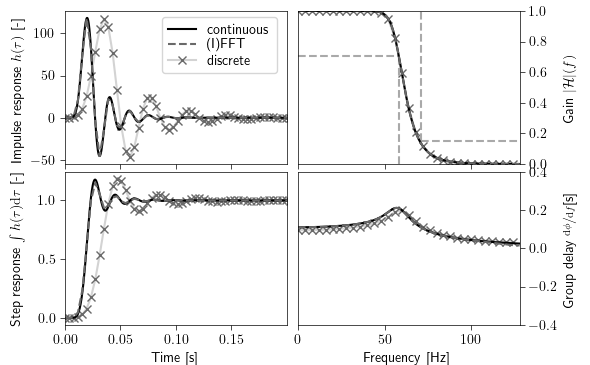

10


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/scipy/sparse/linalg/matfuncs.py:705: LinAlgWarning: Ill-conditioned matrix (rcond=3.626e-41): result may not be accurate.
  return solve(Q, P)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [68]:
%matplotlib notebook
# using the exact polynomial is not possible, because only the exact gain is available, 
# phase and irf follow from the poles and fpe, respectively, which are not easily available
with matplotlib.rc_context(rc=print_context_dict):
    # plot impulse response, frequency response, step response and phase response / group delay
    fig, axes = plt.subplots(2,2, sharex='col')
    (ax11,ax21,ax12,ax22) = axes.flat
    leg_handles = []

    # input parameters
    fs=256
    #fs=16*2*np.pi
    N=4096

    df=fs/N
    dur=1/df
    dt=1/fs

    tim = np.linspace(0,dur-dt,N)

    # tim = np.linspace(0,0.05,N)
    freq = np.fft.fftshift(np.fft.fftfreq(N,dt))

    tolp=1-10**(-3/20)#0.1 #durchlassbereich
    tols=0.15#sperrbereich
    wpass=58.19*2*np.pi
    wstop=71.12*2*np.pi
    gpass = np.log10(1-tolp)*(-20)
    gstop = np.log10(tols)*(-20)
    

    #generate analog system
    sys = signal.iirdesign(wpass, wstop, 
                           gpass, gstop,
                           analog=True, ftype='butter')

    # sys = signal.iirfilter(3,[1000,32000],
    #                        analog=True, ftype='butter')

    r,p,k = signal.residue(*sys)
    M=r.size
    print(M)
    #     print(r,p,k)
    tim_=np.linspace(0,0.2,1000)
    h=np.zeros_like(tim_,dtype=complex)
    for k in range(M):
        h+=r[k]*np.exp(p[k]*tim_)
    ax12.plot(tim_,scipy.integrate.cumtrapz(h,dx=tim_[1]-tim_[0], initial=0),color='k')
    h1,=ax11.plot(tim_,h, color='k', label='continuous')


    sys = signal.lti(*sys)
    w,frf = sys.freqresp(w=freq*2*np.pi)
    w/=2*np.pi
    T,irf = sys.impulse(T=tim)

    # T,irf = sys.impulse(T=np.linspace(0,1e-3,1000))
    T,srf = sys.step(T=tim)
    # T,srf = sys.step(T=T)
    # T*=1000
    angle = np.unwrap(np.angle(frf))
    group_delay = -np.diff(angle,prepend=-angle[-1:])/df




    #frf = np.fft.fft(irf)*dt

    # plot IRF and step response
    # h1,=ax11.plot(T,irf, color='k', label='continuous')
    # ax12.plot(T,srf, color='k')
    # plot frequency response and group delay
    ax21.plot(w,np.abs(frf), color='k')
    ax22.plot(w,group_delay, color='k')

    firf = np.fft.ifft(np.fft.ifftshift(frf))*fs
    ffrf = np.fft.fftshift(np.fft.fft(irf)/fs)
    fsrf = scipy.integrate.cumtrapz(irf,dx=dt, initial=0)
    fangle = np.unwrap(np.angle(ffrf))
    fgroup_delay = -np.diff(fangle,prepend=-fangle[-1:])/df

    # plot IRF and step response
    h2,=ax11.plot(T,firf,ls='dashed', color='dimgrey', label='(I)FFT')
    ax12.plot(T, fsrf,ls='dashed', color='dimgrey')
    # plot frequency response and group delay
    ax21.plot(w,np.abs(ffrf),ls='dashed', color='dimgrey')
    ax22.plot(w,fgroup_delay,ls='dashed', color='dimgrey')



    N=64

    df=fs/N
    dur=1/df

    tim = np.linspace(0,dur-dt,N)
    freq = np.fft.fftshift(np.fft.fftfreq(N,dt))

    #generate discrete system
    dsys=signal.iirdesign(wpass/(fs*2*np.pi),wstop/(fs*2*np.pi), 
                          gpass, gstop, 
                          analog=False, ftype='butter')


    dsys=signal.dlti(*dsys,dt=dt)

    dw,dfrf = dsys.freqresp(w=freq*np.pi/fs)
    dw*=fs/np.pi
    dT,dirf = dsys.impulse(t=tim)
    dirf = np.squeeze(dirf)*2*fs/N
    dT,dsrf = dsys.step(t=tim)
    dsrf = np.squeeze(dsrf)
    dangle = np.unwrap(np.angle(dfrf))
    dgroup_delay = -np.diff(dangle,prepend=-dangle[-1:])/df

    # plot IRF and step response
    h3,=ax11.plot(dT,dirf*N,color='lightgrey',marker='x',zorder=0, mec='dimgrey', label='discrete')
    ax12.plot(dT,dsrf,color='lightgrey',marker='x',zorder=0, mec='dimgrey')
    #ax12.plot(tim[1:], scipy.integrate.cumtrapz(irf,dx=dt))
    # plot frequency response and group delay
    ax21.plot(dw,np.abs(dfrf),color='lightgrey',marker='x',zorder=0, mec='dimgrey')
    ax22.plot(dw,dgroup_delay,color='lightgrey',marker='x',zorder=0, mec='dimgrey')



    ax21.vlines(wpass/2/np.pi,0,(1-tolp), color='darkgrey',ls='dashed')
    ax21.vlines(wstop/2/np.pi, tols,ymax, color='darkgrey',ls='dashed')
    ax21.hlines(1-tolp,0,wpass/2/np.pi, color='darkgrey',ls='dashed')
    ax21.hlines(tols,wstop/2/np.pi,fs/2, color='darkgrey',ls='dashed')



    # plot beautification
    ax21.set_ylabel('Gain $|\\mathcal{H}| (f) $')
    ax21.yaxis.set_label_position("right")
    ax21.yaxis.tick_right()
    ax21.set_ylim((0,1))

    ax22.set_ylabel('Group delay $\\sfrac{\\mathrm{d}\\phi}{\\mathrm{d}f}$[s]')
    ax22.set_ylim((-0.4,0.4))
    ax22.yaxis.set_label_position("right")
    ax22.yaxis.tick_right()
    ax22.set_xlim((0,fs/2))
    ax22.set_xlabel('Frequency [Hz]')

    ax11.set_ylabel('Impulse response $h(\\tau)$ [-]')

    ax12.set_ylabel('Step response $\\int h(\\tau) \mathrm{d} \\tau$ [-]')
    ax12.set_xlabel('Time [s]')
    ax12.set_xlim((0,0.1999999))

    fig.subplots_adjust(top=0.970,bottom=0.11,left=0.11, right=0.88, wspace=0.05,hspace=0.05)
    fig.legend(handles=[h1,h2,h3], loc=(0.275,0.8))
    fig.align_ylabels()
    fig.align_xlabels()

    fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/butter.pdf')
    fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/butter.png')
    plt.show()


<IPython.core.display.Javascript object>


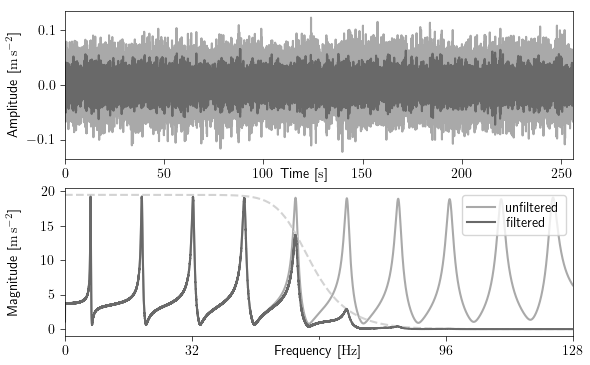

In [21]:
# system generation
N=2**16
fs=256
df=fs/N
dur=1/df
dt=1/fs

tolp=1-10**(-3/20)#0.1 #durchlassbereich
tols=0.15#sperrbereich
wpass=58.19*2*np.pi
wstop=71.12*2*np.pi
gpass = np.log10(1-tolp)*(-20)
gstop = np.log10(tols)*(-20)


rho = 7850
A = 0.0343
L = 200
m = rho*A*L
modmass = m/2
omegas,frf = system_frf(N,fs/2,L,2.1e11,rho,A,0.01)

# system input (white noise)
phase=np.linspace(0,np.pi,N//2+1)
phase=(np.random.rand(N//2+1)-0.5)
Pomega = 10000*np.ones_like(frf)*np.exp(1j*phase*2*np.pi)/modmass

# time domain signal (system output = filter input)
sig=np.fft.irfft(frf*Pomega)

df = (omegas[1]-omegas[0])/2/np.pi
dt = 1/df/N
t = np.linspace(0,(N-1)*dt,N)
with matplotlib.rc_context(rc=print_context_dict):
    fig, (ax31,ax32)=plt.subplots(2,1,)

    h1,=ax31.plot(t,sig, color='darkgrey',label='unfiltered')
    ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig))), color='darkgrey')
    
    
    dsys=signal.iirdesign(wpass/(fs*np.pi),wstop/(fs*np.pi), 
                      gpass, gstop, 
                      analog=False, ftype='butter', output='sos')
    sig_filt = signal.sosfilt(dsys, sig)
    omegas_, h = signal.freqz(*signal.sos2tf(dsys), worN=np.linspace(0,np.pi,128))
    omegas_*=dws/np.pi
    ax32.plot(omegas_/2/np.pi, np.abs(h)*19.5,color='lightgrey', ls='dashed')

    h2,=ax31.plot(t,sig_filt,color='dimgrey',label='filtered')
    ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig_filt.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig_filt))), color='dimgrey')

    m = np.fft.ifftshift(np.linspace(-N//2,N//2-1,N))

    ax32.set_xlim(xmin=0,xmax=fs/2)
    ax31.set_xlim(xmin=0,xmax=t.max())
    ax31.set_ylabel("Amplitude [\\si{\\metre\\per\\second\\squared}]")
    ax31.set_xlabel("Time [\\si{\\second}]",labelpad=-9,backgroundcolor='white',x=0.47)
    ax32.set_ylabel("Magnitude [\\si{\\metre\\per\\second\\squared}]")
    ax32.set_xlabel("Frequency [\\si{\\hertz}]",labelpad=-9,backgroundcolor='white')
    ax32.xaxis.set_major_locator(plt.MultipleLocator(32))
    fig.subplots_adjust(top=0.970,bottom=0.08,left=0.11, right=0.97, wspace=0.2,hspace=0.2)
    ax32.legend(handles=[h1,h2],loc='upper right')
    fig.align_ylabels()
    
    
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/butter_example.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/butter_example.png')

<IPython.core.display.Javascript object>


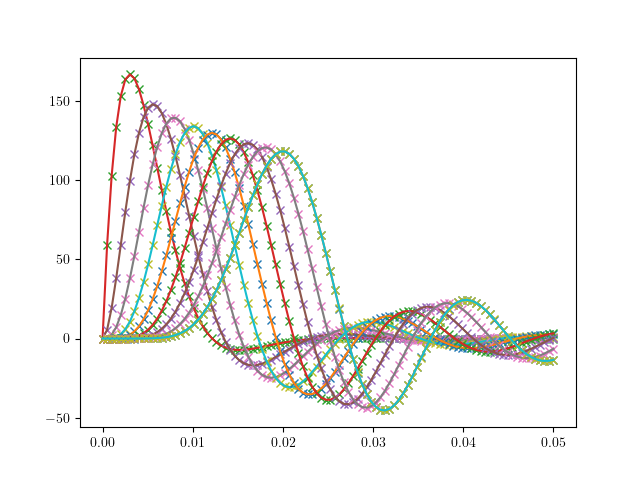

10


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/scipy/sparse/linalg/matfuncs.py:705: LinAlgWarning: Ill-conditioned matrix (rcond=3.38925e-41): result may not be accurate.
  return solve(Q, P)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Castin

In [22]:
plt.figure()
b,a = signal.iirdesign(wpass, wstop, 
                       gpass, gstop,
                       analog=True, ftype='butter')

# print(b,a)
tim=np.linspace(0,0.05,100)
T,irf = signal.impulse((b,a),T=tim)
plt.plot(T,irf,marker='x',ls='none')
r,p,k = signal.residue(b,a)
#     print(r,p,k)

h=np.zeros_like(tim,dtype=complex)
M=r.size
print(M)
for k in range(M):
    h+=r[k]*np.exp(p[k]*tim)
plt.plot(tim,h)

for M in range(2,11):
    b,a=signal.butter(M, wpass, analog=True)
    T,irf = signal.impulse((b,a),T=tim)
    plt.plot(T,irf,marker='x',ls='none')
    r,p,k = signal.residue(b,a)
#     print(r,p,k)
    h=np.zeros_like(tim,dtype=complex)
    for k in range(M):
        h+=r[k]*np.exp(p[k]*tim)
    plt.plot(tim,h)
    
# plt.xlim((0,20))
plt.show()

### Chebychev filter: analytic and using scipy.signal

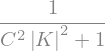

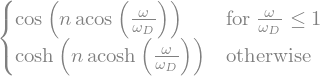

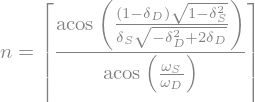

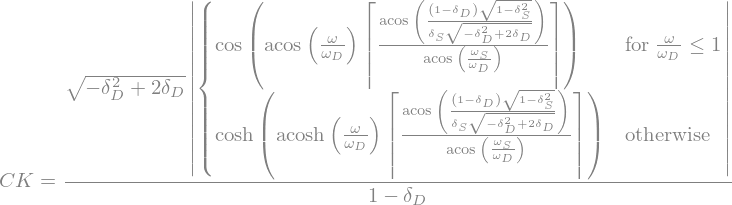

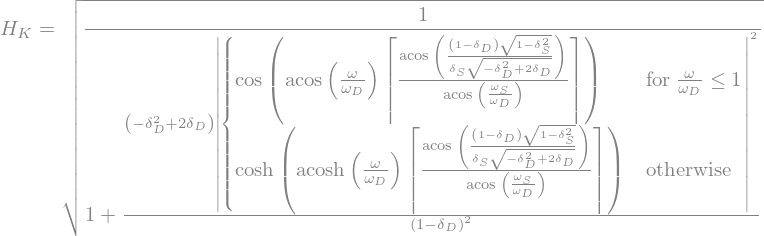

<IPython.core.display.Javascript object>


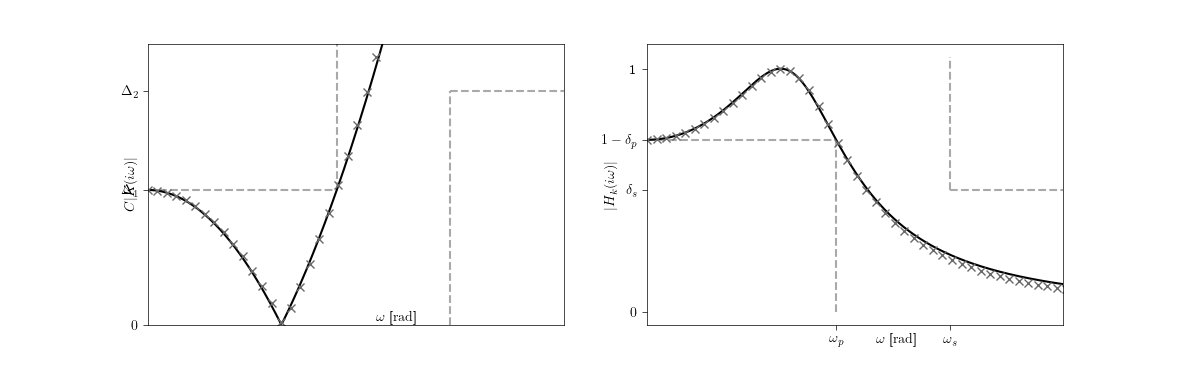

<string>:2: RuntimeWarning: invalid value encountered in arccos
<string>:2: RuntimeWarning: invalid value encountered in arccosh
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in arccos
<string>:2: RuntimeWarning: invalid value encountered in arccosh


In [23]:
H,C,K,w,dD,dS,wD,wS,n=symbols('H_K C K \\omega \\delta_D \\delta_S \\omega_D \\omega_S n')
_H=1/(1+C**2*abs(K)**2)
display(_H)
wp=w/wD
wps=wS/wD

chebypol=Piecewise((cos(n*acos(wp)),wp<=1),(cosh(n*acosh(wp)),wp>1))
display(chebypol)

D1=sqrt(2*dD-dD**2)/(1-dD)
D2=sqrt(1-dS**2)/dS
n_=acos(D2/D1)/acos(wps) # convert to integer, even order not necessary
n_=ceiling(n_)
cheby=sqrt(_H.subs(K,chebypol).subs(C,D1).subs(n,n_))

display(Eq(symbols('n'),n_))
display(Eq(C*K,D1*abs(chebypol.subs(n,n_))))
display(Eq(H,cheby))



tolpass=1-10**(-3/20)#0.1 #durchlassbereich
tolstop=0.5#sperrbereich
dwpass=20*2*np.pi
dwstop=32*2*np.pi
gpass = np.log10(1-tolpass)*(-20)
gstop = np.log10(tolstop)*(-20)


fun=(D1*abs(chebypol.subs(n,n_))).subs(dD,tolpass).subs(dS,tolstop).subs(wD,dwpass).subs(wS,dwstop)
fun=lambdify(w,fun)
dwmax=2*dwstop+-dwpass
dws=128*2*np.pi
omegas = np.linspace(0,dws,1000)

system = signal.iirdesign(dwpass/(dws), dwstop/(dws), gpass, gstop,analog=False, ftype='cheby1')
omegas_, h = signal.freqz(*system, worN=np.linspace(0,np.pi,128))
omegas_*=dws/np.pi


with matplotlib.rc_context(rc=print_context_dict):
    fig,axes = plt.subplots(1,2, figsize=(5.906*2,5.906/1.618))
    axes[0].plot(omegas,fun(omegas),color='k')
    axes[0].plot(omegas_,np.sqrt(1/np.abs(h)**2-1),ls='none',marker='x',color='dimgrey')
    thisD1=float(D1.subs(dD,tolpass).subs(dS,tolstop).subs(wD,wpass).subs(wS,wstop))
    thisD2=float(D2.subs(dD,tolpass).subs(dS,tolstop).subs(wD,wpass).subs(wS,wstop))
    ymax=1.2*thisD2
    axes[0].set_ylim((0,ymax))
    axes[0].vlines(dwpass,thisD1,ymax, color='darkgrey',ls='dashed')
    axes[0].vlines(dwstop,0,thisD2, color='darkgrey',ls='dashed')
    axes[0].hlines(thisD1,0,dwpass, color='darkgrey',ls='dashed')
    axes[0].hlines(thisD2,dwstop,dwmax, color='darkgrey',ls='dashed')
    axes[0].set_ylabel('$C|K(i\\omega)|$',labelpad=-12)
    axes[0].set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.6)
    
    axes[0].set_xticks([wpass,wstop])
    axes[0].set_xticklabels(['$\\omega_p$',"$\\omega_s$"])
    axes[0].set_yticks([0,thisD1,thisD2])
    axes[0].set_yticklabels(['$0$','$\\Delta_1$',"$\\Delta_2$"])
    axes[0].set_xlim((0,dwmax))


    fun=(cheby.subs(dD,tolpass).subs(dS,tolstop).subs(wD,dwpass).subs(wS,dwstop))
    fun=lambdify(w,fun)

    #fig,ax = plt.subplots()
    axes[1].plot(omegas,fun(omegas),color='k')
    axes[1].plot(omegas_,np.abs(h),ls='none',marker='x',color='dimgrey')
    ymax=axes[1].get_ylim()[1]
    axes[1].vlines(dwpass,0,(1-tolpass), color='darkgrey',ls='dashed')
    axes[1].vlines(dwstop, tolstop,ymax, color='darkgrey',ls='dashed')
    axes[1].hlines(1-tolpass,0,dwpass, color='darkgrey',ls='dashed')
    axes[1].hlines(tolstop,dwstop,dwmax, color='darkgrey',ls='dashed')
    axes[1].set_ylabel('$|H_k(i\\omega)|$',labelpad=-12)
    axes[1].set_xlabel('$\\omega$ [\\si{\\radian}]',labelpad=-10, x = 0.6)

    axes[1].set_xticks([dwpass,dwstop])
    axes[1].set_xticklabels(['$\\omega_p$','$\\omega_s$'])
    axes[1].set_yticks([0,tolstop,1-tolpass,1])
    axes[1].set_yticklabels(['$0$','$\\delta_s$',"$1-\\delta_p$",'1'])
    axes[1].set_xlim((0,dwmax))


order=float(n_.subs(dD,tolpass).subs(dS,tolstop).subs(wD,wpass).subs(wS,wstop))
display(Eq(symbols('n'),order))
display(Eq(symbols('\\Delta_1'),thisD1))
display(Eq(symbols('\\Delta_2'),thisD2))

<IPython.core.display.Javascript object>


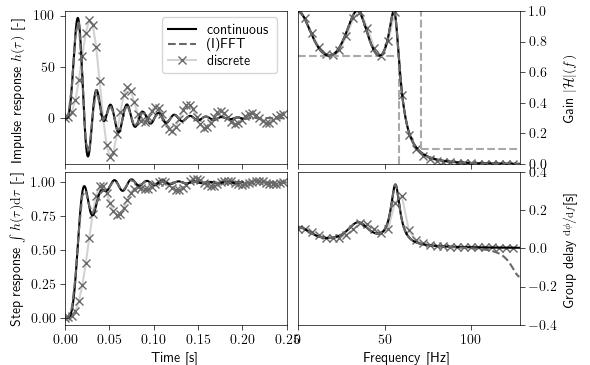

5


/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/scipy/sparse/linalg/matfuncs.py:705: LinAlgWarning: Ill-conditioned matrix (rcond=9.71961e-17): result may not be accurate.
  return solve(Q, P)
/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [72]:
%matplotlib notebook

with matplotlib.rc_context(rc=print_context_dict):
    # plot impulse response, frequency response, step response and phase response / group delay
    fig, axes = plt.subplots(2,2, sharex='col')
    (ax11,ax21,ax12,ax22) = axes.flat
    leg_handles = []

    # input parameters
    fs=256
    #fs=16*2*np.pi
    N=2048

    df=fs/N
    dur=1/df
    dt=1/fs

    tim = np.linspace(0,dur-dt,N)
    freq = np.fft.fftshift(np.fft.fftfreq(N,dt))

    tolp=1-10**(-3/20)#0.1 #durchlassbereich
    tols=0.1#sperrbereich
    wpass=58.19*2*np.pi
    wstop=71.12*2*np.pi
    gpass = np.log10(1-tolp)*(-20)
    gstop = np.log10(tols)*(-20)


    #generate analog system
    sys = signal.iirdesign(wpass, wstop, 
                           gpass, gstop,
                           analog=True, ftype='cheby1')
    
    r,p,k = signal.residue(*sys)
    M=r.size
    print(M)
    #     print(r,p,k)
    tim_=np.linspace(0,0.2,1000)
    h=np.zeros_like(tim_,dtype=complex)
    for k in range(M):
        h+=r[k]*np.exp(p[k]*tim_)
    ax12.plot(tim_,scipy.integrate.cumtrapz(h,dx=tim_[1]-tim_[0], initial=0),color='k')
    h1,=ax11.plot(tim_,h, color='k', label='continuous')
    
    
    sys = signal.lti(*sys)
    w,frf = sys.freqresp(w=freq*2*np.pi)
    w/=2*np.pi
    T,irf = sys.impulse(T=tim)
    T,srf = sys.step(T=tim)
    angle = np.unwrap(np.angle(frf))
    group_delay = -np.diff(angle,prepend=-angle[-1:])/df

    #frf = np.fft.fft(irf)*dt

    # plot IRF and step response
#     h1,=ax11.plot(T,irf, color='k', label='continuous')
#     ax12.plot(T,srf, color='k')
    # plot frequency response and group delay
    ax21.plot(w,np.abs(frf), color='k')
    ax22.plot(w,group_delay, color='k')

    firf = np.fft.ifft(np.fft.ifftshift(frf))*fs
    ffrf = np.fft.fftshift(np.fft.fft(irf)/fs)
    fsrf = scipy.integrate.cumtrapz(irf,dx=dt, initial=0)
    fangle = np.unwrap(np.angle(ffrf))
    fgroup_delay = -np.diff(fangle,prepend=-fangle[-1:])/df

    # plot IRF and step response
    h2,=ax11.plot(T,firf,ls='dashed', color='dimgrey', label='(I)FFT')
    ax12.plot(T, fsrf,ls='dashed', color='dimgrey')
    # plot frequency response and group delay
    ax21.plot(w,np.abs(ffrf),ls='dashed', color='dimgrey')
    ax22.plot(w,fgroup_delay,ls='dashed', color='dimgrey')



    N=64

    df=fs/N
    dur=1/df

    tim = np.linspace(0,dur-dt,N)
    freq = np.fft.fftshift(np.fft.fftfreq(N,dt))

    #generate discrete system
    dsys=signal.iirdesign(wpass/(fs*2*np.pi),wstop/(fs*2*np.pi), 
                          gpass, gstop, 
                          analog=False, ftype='cheby1')


    dsys=signal.dlti(*dsys,dt=dt)

    dw,dfrf = dsys.freqresp(w=freq*np.pi/fs)
    dw*=fs/np.pi
    dT,dirf = dsys.impulse(t=tim)
    dirf = np.squeeze(dirf)*2*fs/N
    dT,dsrf = dsys.step(t=tim)
    dsrf = np.squeeze(dsrf)
    dangle = np.unwrap(np.angle(dfrf))
    dgroup_delay = -np.diff(dangle,prepend=-dangle[-1:])/df

    # plot IRF and step response
    h3,=ax11.plot(dT,dirf*N,color='lightgrey',marker='x',zorder=0, mec='dimgrey', label='discrete')
    ax12.plot(dT,dsrf,color='lightgrey',marker='x',zorder=0, mec='dimgrey')
    #ax12.plot(tim[1:], scipy.integrate.cumtrapz(irf,dx=dt))
    # plot frequency response and group delay
    ax21.plot(dw,np.abs(dfrf),color='lightgrey',marker='x',zorder=0, mec='dimgrey')
    ax22.plot(dw,dgroup_delay,color='lightgrey',marker='x',zorder=0, mec='dimgrey')






    ax21.vlines(wpass/2/np.pi,0,(1-tolp), color='darkgrey',ls='dashed')
    ax21.vlines(wstop/2/np.pi, tols,ymax, color='darkgrey',ls='dashed')
    ax21.hlines(1-tolp,0,wpass/2/np.pi, color='darkgrey',ls='dashed')
    ax21.hlines(tols,wstop/2/np.pi,fs/2, color='darkgrey',ls='dashed')



    # plot beautification
    ax21.set_ylabel('Gain $|\\mathcal{H}| (f) $')
    ax21.yaxis.set_label_position("right")
    ax21.yaxis.tick_right()
    ax21.set_ylim((0,1))

    ax22.set_ylabel('Group delay $\\sfrac{\\mathrm{d}\\phi}{\\mathrm{d}f}$[s]')
    ax22.set_ylim((-0.4,0.4))
    ax22.yaxis.set_label_position("right")
    ax22.yaxis.tick_right()
    ax22.set_xlim((0,fs/2))
    ax22.set_xlabel('Frequency [Hz]')

    ax11.set_ylabel('Impulse response $h(\\tau)$ [-]')

    ax12.set_ylabel('Step response $\\int h(\\tau) \mathrm{d} \\tau$ [-]')
    ax12.set_xlabel('Time [s]')
    ax12.set_xlim((0,np.max(dur)))

    fig.subplots_adjust(top=0.970,bottom=0.11,left=0.11, right=0.88, wspace=0.05,hspace=0.05)
    fig.legend(handles=[h1,h2,h3], loc=(0.275,0.8))
    fig.align_ylabels()
    fig.align_xlabels()

#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/cheby1.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/cheby1.png')
    plt.show()


<IPython.core.display.Javascript object>


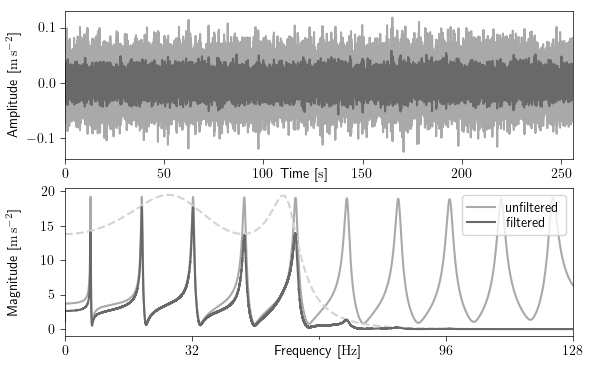

In [25]:
# system generation
N=2**16
fs=256
df=fs/N
dur=1/df
dt=1/fs

tolp=1-10**(-3/20)#0.1 #durchlassbereich
tols=0.15#sperrbereich
wpass=58.19*2*np.pi
wstop=71.12*2*np.pi
gpass = np.log10(1-tolp)*(-20)
gstop = np.log10(tols)*(-20)


rho = 7850
A = 0.0343
L = 200
m = rho*A*L
modmass = m/2
omegas,frf = system_frf(N,fs/2,L,2.1e11,rho,A,0.01)

# system input (white noise)
phase=np.linspace(0,np.pi,N//2+1)
phase=(np.random.rand(N//2+1)-0.5)
Pomega = 10000*np.ones_like(frf)*np.exp(1j*phase*2*np.pi)/modmass

# time domain signal (system output = filter input)
sig=np.fft.irfft(frf*Pomega)

df = (omegas[1]-omegas[0])/2/np.pi
dt = 1/df/N
t = np.linspace(0,(N-1)*dt,N)
with matplotlib.rc_context(rc=print_context_dict):
    fig, (ax31,ax32)=plt.subplots(2,1,)

    h1,=ax31.plot(t,sig, color='darkgrey',label='unfiltered')
    ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig))), color='darkgrey')
    
    
    dsys=signal.iirdesign(wpass/(fs*np.pi),wstop/(fs*np.pi), 
                      gpass, gstop, 
                      analog=False, ftype='cheby1', output='sos')
    sig_filt = signal.sosfilt(dsys, sig)
    omegas_, h = signal.freqz(*signal.sos2tf(dsys), worN=np.linspace(0,np.pi,128))
    omegas_*=dws/np.pi
    ax32.plot(omegas_/2/np.pi, np.abs(h)*19.5,color='lightgrey', ls='dashed')

    h2,=ax31.plot(t,sig_filt,color='dimgrey',label='filtered')
    ax32.plot(np.fft.fftshift(np.fft.fftfreq(sig_filt.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig_filt))), color='dimgrey')

    m = np.fft.ifftshift(np.linspace(-N//2,N//2-1,N))

    ax32.set_xlim(xmin=0,xmax=fs/2)
    ax31.set_xlim(xmin=0,xmax=t.max())
    ax31.set_ylabel("Amplitude [\\si{\\metre\\per\\second\\squared}]")
    ax31.set_xlabel("Time [\\si{\\second}]",labelpad=-9,backgroundcolor='white',x=0.47)
    ax32.set_ylabel("Magnitude [\\si{\\metre\\per\\second\\squared}]")
    ax32.set_xlabel("Frequency [\\si{\\hertz}]",labelpad=-9,backgroundcolor='white')
    ax32.xaxis.set_major_locator(plt.MultipleLocator(32))
    fig.subplots_adjust(top=0.970,bottom=0.08,left=0.11, right=0.97, wspace=0.2,hspace=0.2)
    ax32.legend(handles=[h1,h2],loc='upper right')
    fig.align_ylabels()
    
    
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/cheby1_example.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/cheby1_example.png')

[0.00000000e+00 3.90625000e-03 7.81250000e-03 ... 2.55988281e+02
 2.55992188e+02 2.55996094e+02] [-5.01538194 -8.34197085  3.92138336 ...  0.63149884 -0.89118007
  1.49013663]


<IPython.core.display.Javascript object>


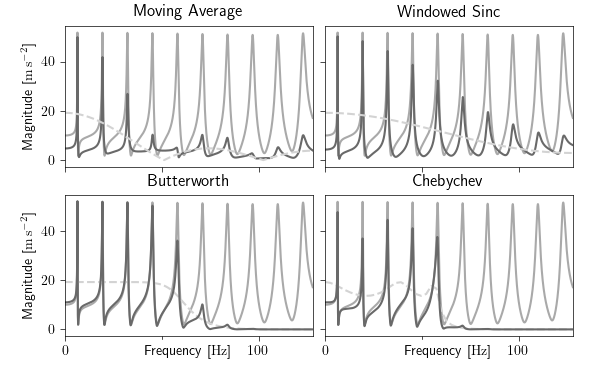

<IPython.core.display.Javascript object>


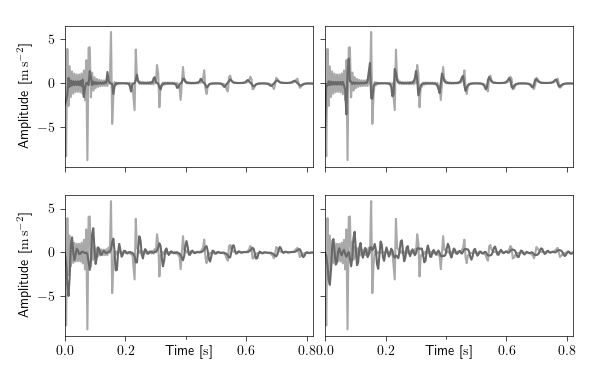

(array([0.03632586, 0.18162932, 0.36325864, 0.36325864, 0.18162932,
       0.03632586, 0.        ]), array([ 1.        , -0.44691216,  0.70331957, -0.15628709,  0.06650648,
       -0.00419918,  0.        ]))
(array([0.00963659, 0.04818294, 0.09636589, 0.09636589, 0.04818294,
       0.00963659, 0.        ]), array([ 1.        , -1.99925925,  2.80660316, -2.43701678,  1.38069138,
       -0.44264766,  0.        ]))


In [168]:
# system generation
N=2**16
fs=256
df=fs/N
dur=1/df
dt=1/fs

tolp=1-10**(-3/20)#0.1 #durchlassbereich
tols=0.15#sperrbereich
wpass=58.19*2*np.pi
wstop=71.12*2*np.pi
gpass = np.log10(1-tolp)*(-20)
gstop = np.log10(tols)*(-20)
M=5


rho = 7850
A = 0.0343
L = 200
m = rho*A*L
modmass = m/2
omegas, frf = system_frf(N,fs/2,L,2.1e11,rho,A,0.01)

# system input (white noise)
phase=np.linspace(0,np.pi,N//2+1)
phase=(np.random.rand(N//2+1)-0.5)
Pomega = 10000*np.ones_like(frf)*np.exp(1j*phase*2*np.pi)/modmass

# time domain signal (system output = filter input)
sig=np.fft.irfft(frf*Pomega)
sig=np.fft.irfft(frf)
t = np.linspace(0,(N-1)*dt,N)
print(t,sig)

with matplotlib.rc_context(rc=print_context_dict):
    fig, axes=plt.subplots(2,2,sharex=True, sharey=True)
    ax11,ax12,ax21,ax22 = axes.flat
    fig2, axes2=plt.subplots(2,2,sharex=True, sharey=True)
    ax31,ax32,ax41,ax42 = axes2.flat
    
    ax11.plot(np.fft.fftshift(np.fft.fftfreq(sig.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig))), color='darkgrey')
    ax12.plot(np.fft.fftshift(np.fft.fftfreq(sig.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig))), color='darkgrey')
    ax21.plot(np.fft.fftshift(np.fft.fftfreq(sig.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig))), color='darkgrey')
    ax22.plot(np.fft.fftshift(np.fft.fftfreq(sig.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig))), color='darkgrey')
    
    ax31.plot(t,sig, color='darkgrey')
    ax32.plot(t,sig, color='darkgrey')
    ax41.plot(t,sig, color='darkgrey')
    ax42.plot(t,sig, color='darkgrey')
    
    
    '''
    Moving average
    '''
    sig_filt = np.convolve(sig, np.ones(M)/M)
    nN=M-1
    sig_filt=sig_filt[nN//2+1:-nN//2+1] # truncate excessive length due to convolution
    ax11.plot(np.fft.fftshift(np.fft.fftfreq(sig_filt.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig_filt))), color='dimgrey')
    irf = np.zeros(N)
    irf[:M] = 1/M
    frf2 = np.fft.fft(irf)
    ax11.plot(np.fft.fftshift(np.fft.fftfreq(frf2.shape[0],dt)),np.fft.fftshift(np.abs(frf2))*19.213,color='lightgrey', ls='dashed')
    ax11.set_title("Moving Average")
    
    ax31.plot(t,sig_filt, color='dimgrey')
    
    '''
    Brickwall
    '''
    fir_firwin = signal.firwin(numtaps=M, cutoff=wpass/2/np.pi, fs=fs)
    
    sig_filt = np.convolve(sig, fir_firwin)
    nN=fir_firwin.shape[0]-1
    sig_filt=sig_filt[nN//2+1:-nN//2+1] # truncate excessive length due to convolution
    ax12.plot(np.fft.fftshift(np.fft.fftfreq(sig_filt.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig_filt))), color='dimgrey')
    irf=np.zeros(N)
    irf[:M]=fir_firwin
    frf2 = np.fft.fft(irf)
    ax12.plot(np.fft.fftshift(np.fft.fftfreq(frf2.shape[0],dt)),np.fft.fftshift(np.abs(frf2))*19.213,color='lightgrey', ls='dashed')
    ax12.set_title("Windowed Sinc")
    
    ax32.plot(t,sig_filt, color='dimgrey')
    
    '''
    Butterworth
    '''
    dsys=signal.iirdesign(wpass/(fs*np.pi),wstop/(fs*np.pi), 
                      gpass, gstop, 
                      analog=False, ftype='butter', output='sos')
    dsys=signal.iirfilter(M, wpass/(fs*np.pi), analog=False, btype='low',ftype='butter', output='sos')
    print(signal.sos2tf(dsys))
    sig_filt = signal.sosfilt(dsys, sig)
    omegas_, h = signal.freqz(*signal.sos2tf(dsys), worN=np.linspace(0,np.pi,128))

    ax21.plot(omegas_*fs/2/np.pi, np.abs(h)*19.213,color='lightgrey', ls='dashed')

#     h2,=ax31.plot(t,sig_filt,color='dimgrey',label='butterworth')
    
    ax21.plot(np.fft.fftshift(np.fft.fftfreq(sig_filt.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig_filt))), color='dimgrey')
    ax21.set_title("Butterworth")
    
    ax41.plot(t,sig_filt, color='dimgrey')
    '''
    Chebychev
    '''
    dsys=signal.iirdesign(wpass/(fs*np.pi),wstop/(fs*np.pi), 
                      gpass, gstop, 
                      analog=False, ftype='cheby1', output='sos')
    dsys=signal.iirfilter(M, wpass/(fs*np.pi), gpass, analog=False, btype='low', ftype='cheby1', output='sos')
    sig_filt = signal.sosfilt(dsys, sig)
    print(signal.sos2tf(dsys))
    omegas_, h = signal.freqz(*signal.sos2tf(dsys), worN=np.linspace(0,np.pi))

    ax22.plot(omegas_*fs/2/np.pi, np.abs(h)*19.213,color='lightgrey', ls='dashed')
    ax22.plot(np.fft.fftshift(np.fft.fftfreq(sig_filt.shape[0],dt)),np.fft.fftshift(np.abs(np.fft.fft(sig_filt))), color='dimgrey')
    ax22.set_title("Chebychev")
    
    
    ax42.plot(t,sig_filt, color='dimgrey')
    

    ax11.set_xlim(xmin=0,xmax=fs/2)
#     ax11.set_ylim(ymin=-0.5,ymax=21)
    ax11.set_ylabel("Magnitude [\\si{\\metre\\per\\second\\squared}]")
    ax21.set_ylabel("Magnitude [\\si{\\metre\\per\\second\\squared}]")
    ax21.set_xlabel("Frequency [\\si{\\hertz}]",labelpad=-9,backgroundcolor='white')
    ax22.set_xlabel("Frequency [\\si{\\hertz}]",labelpad=-9,backgroundcolor='white')
    fig.subplots_adjust(top=0.93,bottom=0.08,left=0.11, right=0.97, wspace=0.05,hspace=0.2)
    fig.align_ylabels()
    
    
    ax31.set_xlim(xmin=0,xmax=0.82)
#     ax11.set_ylim(ymin=-0.5,ymax=21)
    ax31.set_ylabel("Amplitude [\\si{\\metre\\per\\second\\squared}]")
    ax41.set_ylabel("Amplitude [\\si{\\metre\\per\\second\\squared}]")
    ax41.set_xlabel("Time [\\si{\\second}]",labelpad=-9,backgroundcolor='white')
    ax42.set_xlabel("Time [\\si{\\second}]",labelpad=-9,backgroundcolor='white')
    fig2.subplots_adjust(top=0.93,bottom=0.08,left=0.11, right=0.97, wspace=0.05,hspace=0.2)
    fig2.align_ylabels()
    
    
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter4_example.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/filter4_example.png')

In [103]:
omegas/fs/2/np.pi

array([0.00000000e+00, 1.52583234e-05, 3.05166468e-05, ...,
       4.99954225e-01, 4.99969483e-01, 4.99984742e-01])

In [26]:
def ashift(array):
    return np.fft.fftshift(np.abs(array))

def quantify_aliasing_noise(sig, dec_fact, dt=1, numtaps_fact=41, nyq_rat=2.5 , do_plot=False):
    N=sig.size
    fs=1/dt
    
    dt_dec=dt*dec_fact
    N_dec = int(np.floor(N/dec_fact)) 
    # ceil would also work, but breaks indexing for aliasing noise estimation
    # with floor though, care must be taken to shorten the time domain signal to N_dec full blocks before slicing
    
    cutoff=fs/nyq_rat/dec_fact
    numtaps= numtaps_fact*dec_fact
    
    t = np.linspace(0,(N-1)*dt,N)
    
    # compute spectrum
    if do_plot:
        fft_sig = np.fft.fft(sig)#/np.sqrt(N)

    # fir lowpass filter
    # fir_firwin = signal.firwin(numtaps, cutoff/fs*2)
    fir_firwin = signal.firwin(numtaps, cutoff,fs=fs)

    #filter signal
    sig_filt = np.convolve(sig, fir_firwin, 'same')
#     sig_filt = np.convolve(sig, np.ones(numtapps), 'same')
    fft_filt = np.fft.fft(sig_filt)#/np.sqrt(N)
    fft_filt_alias = np.copy(fft_filt)


    #decimate signal
    sig_filt_dec = np.copy(sig_filt[0:N_dec*dec_fact:dec_fact])
    # correct for power loss due to decimation
    # https://en.wikipedia.org/wiki/Downsampling_(signal_processing)#Anti-aliasing_filter
    sig_filt_dec*=dec_fact

    #fft_dec = np.fft.fft(sig_dec)#/np.sqrt(N_dec)
    fft_filt_dec = np.fft.fft(sig_filt_dec)#/np.sqrt(N_dec)

    t_dec = t[0::dec_fact]
    if do_plot:
        plt.figure()
        
        freq=np.fft.fftshift(np.fft.fftfreq(N,d=dt))
        plt.plot(freq, ashift(fft_sig), label='original signal', color='lightgrey')
        
        freq_dec=np.fft.fftshift(np.fft.fftfreq(N_dec,d=dt_dec))
        plt.plot(freq_dec, ashift(fft_filt_dec), ls='solid', color='k', label='filtered decimated')
        
#         plt.plot(freq, ashift(fft_filt), label='filtered signal', color='lightgrey')

    fft_filt_alias = np.zeros(N_dec,dtype=complex)
    fft_filt_non_alias = np.zeros(N_dec,dtype=complex)

    fft_filt_non_alias[:N_dec//2] += np.copy(fft_filt[:1*N_dec//2])
    fft_filt_non_alias[N_dec//2:] += np.copy(fft_filt[-1*N_dec//2:])

    pos_alias = fft_filt_alias[:N_dec//2]
    neg_alias = fft_filt_alias[N_dec//2:]

    for i in reversed(range(1,dec_fact)):
        slp=slice(i*N_dec//2,(i+1)*N_dec//2)
        sln=slice(-(i+1)*N_dec//2,-i*N_dec//2)

        if i%2:# alias and fold
            neg=fft_filt[slp]
            pos=fft_filt[sln]
            
            if do_plot:
                ls='dashed'
                color='dimgrey'
                freqp=np.fft.fftfreq(N,d=dt)[sln]
                freqn=np.fft.fftfreq(N,d=dt)[slp]
        else: # alias
            pos=fft_filt[slp]
            neg=fft_filt[sln]
            
            if do_plot:
                ls='dotted'
                color='grey'
                freqp=np.fft.fftfreq(N,d=dt)[slp]
                freqn=np.fft.fftfreq(N,d=dt)[sln]

        pos_alias+=pos
        neg_alias+=neg
        if do_plot:
            plt.plot(freqp, np.abs(pos), color=color)#, ls=ls)#,marker='x')
            plt.plot(freqn, np.abs(neg), color=color)#, ls=ls)#,marker='x')
            plt.plot(np.fft.fftshift(np.fft.fftfreq(N_dec,dt_dec)),np.copy(ashift(fft_filt_alias)), color=color)#, ls=ls)
    else:
        if do_plot:
            plt.plot(np.fft.fftshift(np.fft.fftfreq(N_dec,dt_dec)),
                     np.copy(ashift(fft_filt_alias+fft_filt_non_alias)), color='grey',ls='dotted', label='alias')
    
    p_fft_filt_alias = np.mean(np.abs(fft_filt_alias/np.sqrt(N_dec))**2)
    p_fft_filt_non_alias = np.mean(np.abs(fft_filt_non_alias/np.sqrt(N_dec))**2)
    snr_alias = p_fft_filt_non_alias/p_fft_filt_alias

    if do_plot:
        sig_filt_alias = np.fft.ifft(fft_filt_alias)
        sig_filt_nonalias = np.fft.ifft(fft_filt_non_alias)

        # signal powers
        p_sig = np.mean(np.abs(sig)**2)
        p_fft =np.mean(np.abs(fft_sig/np.sqrt(N))**2)
        p_sig_filt = np.mean(np.abs(sig_filt)**2)
        p_fft_filt = np.mean(np.abs(fft_filt/np.sqrt(N))**2)
        p_sig_filt_dec = np.mean(np.abs(sig_filt_dec)**2)
        p_fft_filt_dec = np.mean(np.abs(fft_filt_dec/np.sqrt(N_dec))**2)
        p_sig_filt_alias = np.mean(np.abs(sig_filt_alias)**2)
        p_fft_filt_alias = np.mean(np.abs(fft_filt_alias/np.sqrt(N_dec))**2)
        p_sig_filt_non_alias = np.mean(np.abs(sig_filt_nonalias)**2)
        p_fft_filt_non_alias = np.mean(np.abs(fft_filt_non_alias/np.sqrt(N_dec))**2)
        print('Power signal: ',p_sig)
        print('Power filtered signal: ',p_sig_filt, 'filtered spectrum: ', p_fft_filt)
        print('Power decimated signal: ',p_sig_filt_dec)
        print('Power alias spectrum: ',p_fft_filt_alias)
        print('Power non-alias spectrum: ',p_fft_filt_non_alias)
        print('SNR alias: ', snr_alias, ' in dB: ', np.log10(snr_alias)*10)

#         freq_dec=np.fft.fftshift(np.fft.fftfreq(N_dec,d=dt_dec))
#         plt.plot(freq_dec, ashift(fft_filt_dec), ls='dashed', color='k', label='filtered decimated')

        plt.xlim(xmin=0,xmax=fs/2)
        plt.ylim(ymin=1e-2)
        plt.axvline(fs/2/dec_fact,color='k')
        plt.axvline(cutoff,ls='dashed',color='k')
        plt.legend()
        plt.yscale('log')
        plt.xlabel("Frequency [\\si{\\hertz}]")
        plt.ylabel("Magnitude [\\si{\\metre\\per\\second\\squared}]")
        plt.subplots_adjust(top=0.970,bottom=0.12,left=0.1, right=0.97)
    
    return sig_filt_dec, snr_alias

<IPython.core.display.Javascript object>


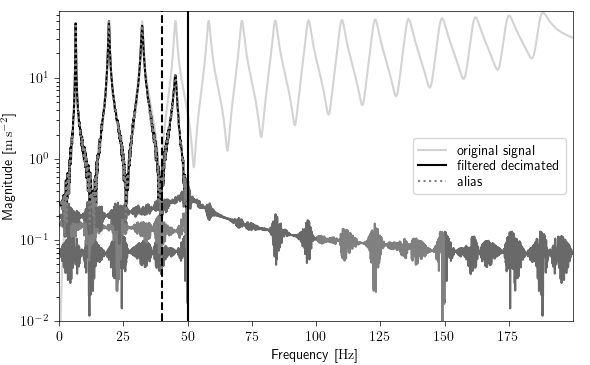

Power signal:  0.15366993571580945
Power filtered signal:  0.00479391842555727 filtered spectrum:  0.004793918425557269
Power decimated signal:  0.07674864300471951
Power alias spectrum:  5.801827409892556e-05
Power non-alias spectrum:  0.07665586558425874
SNR alias:  1321.2365720075484  in dB:  31.2098058651593


In [27]:
def system_signal_decimate(N,dec_fact, numtap_fact, nyq_rat, do_plot=False):
    fmax=200
    df=fmax/(N//2+1)
    dt=1/df/N
    fs=1/dt

    #signal processing parameters
    #dec_fact=4
    #dec_fact=int(inputs[i,1])

    # allocation
    omegas = np.linspace(0,fmax,N//2+1,False)*2*np.pi
    t = np.linspace(0,(N-1)*dt,N)
    frf= np.zeros((N//2+1,), dtype=complex)
    assert df*2*np.pi == (omegas[-1]-omegas[0])/(N//2+1-1)

    # system parameters
    L=200
    E=2.1e11
    rho=7850
    num_modes=int(np.floor((fmax*2*np.pi*np.sqrt(rho/E)*L/np.pi*2+1)/2))

    #system generation
    omegans = (2*np.arange(1,num_modes+1)-1)/2*np.pi/L*np.sqrt(E/rho)
    ks=omegans**2#np.random.rand(num_modes)+0.5
    zetas = np.zeros_like(omegans)
    zetas[:]=0.01
    for k,omegan, zeta in zip(ks,omegans, zetas):
        frf+=-omegas**2/(k*(1+2*1j*zeta*omegas/omegan-(omegas/omegan)**2))

    # random input    
    phase=(np.random.rand(N//2+1)-0.5)
    Pomega = np.ones_like(frf)*np.exp(1j*phase*2*np.pi)

    # time domain signal
    sig=np.fft.irfft(frf*Pomega)
    
    return np.log10(quantify_aliasing_noise(sig,dec_fact,dt,numtap_fact,nyq_rat,do_plot)[1])*10

#%matplotlib inline
# decimate and quantify aliasing noise (-> decimation noise wrt signal length, decimation factor, nyquist factor)
#       keeping the orgiginal frequency band fully populated with max num_modes
# quantify aliasing under noise
# relate numtapps to snr
plt.rc('text',usetex=True)

N=4096
dec_fact=4
numtap_fact=11
nyq_rat=2.5

with matplotlib.rc_context(rc=print_context_dict): 
    system_signal_decimate(N,dec_fact, numtap_fact,nyq_rat, True)
#     plt.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/decimation_noise.pdf')
#     plt.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/decimation_noise.png')



#### Signal power estimation in time- and frequency domain using Parceval's Theorem

100
99.87339789957304


<IPython.core.display.Javascript object>


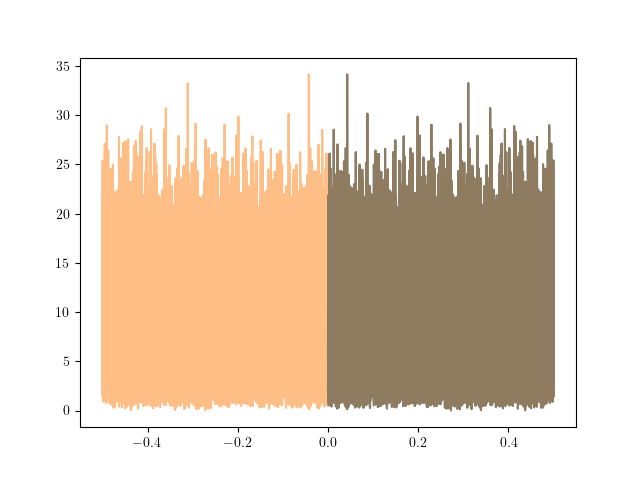

99.87653250949718
99.87339789957302


In [28]:
noise_power=100
print(noise_power)
N=2**16
#ft=np.sin(np.linspace(0,N-1,N))
ft=np.random.normal(0, np.sqrt(noise_power), N)
#ft=np.random.rand(N)*np.sqrt(noise_power*3)
print(np.mean(np.abs(ft)**2))
Ff=np.fft.rfft(ft)/np.sqrt(N)
#Ff=np.concatenate((Ff,np.conj(Ff[-1:1:-1])))
plt.figure()
plt.plot(np.fft.rfftfreq(ft.size),np.abs(Ff))
#plt.plot(np.fft.fftfreq(ft.size),np.abs(Ff))
weights=np.ones(Ff.size)
weights[1:]=2# because everything except the DC component appears twice in normal fft
print(np.average(np.abs(Ff)**2, weights=weights))
#print(np.mean(np.abs(Ff)**2))
Ff=np.fft.fft(ft)/np.sqrt(N)
plt.plot(np.fft.fftfreq(ft.size),np.abs(Ff),alpha=.5)
print(np.mean(np.abs(Ff)**2))
plt.show()

#### Indexing for aliasing and folding components

In [29]:
N=33
dec_fact=4
N_dec=int(np.floor(N/dec_fact))
print(N_dec)
sig=np.linspace(0,N-1,N)
sig_dec = sig[0:N_dec*dec_fact:dec_fact]
print(sig, sig_dec, sig.size, sig_dec.size)
# s=np.random.randn(N)
# a=np.fft.fft(s)
fft_filt=np.fft.fftfreq(N,1/N)
print(fft_filt[0],fft_filt[N//2])
print(fft_filt[1:N//2])
print(fft_filt[N//2+1:N])

print(fft_filt[0])
print(fft_filt[0:N_dec//2],' + ',fft_filt[-2*N_dec//2:-N_dec//2],' + ',fft_filt[2*N_dec//2:3*N_dec//2],' + ',fft_filt[-4*N_dec//2:-3*N_dec//2])
print(fft_filt[-N_dec//2:],' + ',fft_filt[N_dec//2:2*N_dec//2],' + ',fft_filt[-3*N_dec//2:-2*N_dec//2],' + ',fft_filt[3*N_dec//2:4*N_dec//2])


fft_filt_alias = np.zeros(N_dec,dtype=float)


fft_filt_alias[:N_dec//2]=np.copy(fft_filt[:1*N_dec//2])
fft_filt_alias[N_dec//2:]=np.copy(fft_filt[-1*N_dec//2:])
pos_alias = fft_filt_alias[:N_dec//2]
neg_alias = fft_filt_alias[N_dec//2:]
print(fft_filt_alias)
for i in range(1,dec_fact):
    slp=slice(i*N_dec//2,(i+1)*N_dec//2)
    sln=slice(-(i+1)*N_dec//2,-i*N_dec//2)

    if i%2:# alias and fold
        neg=fft_filt[slp]
        pos=fft_filt[sln]
    else: # fold
        pos=fft_filt[slp]
        neg=fft_filt[sln]

    freqp=freq[slp]
    freqn=freq[sln]

    pos_alias+=pos
    neg_alias+=neg

    print('+ ',pos,pos_alias)
    print('- ',neg,neg_alias)
print(fft_filt_alias/dec_fact) # the reversed values are intended

8
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.] [ 0.  4.  8. 12. 16. 20. 24. 28.] 33 8
0.0 16.0
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[-16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.
  -2.  -1.]
0.0
[0. 1. 2. 3.]  +  [-8. -7. -6. -5.]  +  [ 8.  9. 10. 11.]  +  [-16. -15. -14. -13.]
[-4. -3. -2. -1.]  +  [4. 5. 6. 7.]  +  [-12. -11. -10.  -9.]  +  [12. 13. 14. 15.]
[ 0.  1.  2.  3. -4. -3. -2. -1.]
+  [-8. -7. -6. -5.] [-8. -6. -4. -2.]
-  [4. 5. 6. 7.] [0. 2. 4. 6.]
+  [ 8.  9. 10. 11.] [0. 3. 6. 9.]
-  [-12. -11. -10.  -9.] [-12.  -9.  -6.  -3.]
+  [-16. -15. -14. -13.] [-16. -12.  -8.  -4.]
-  [12. 13. 14. 15.] [ 0.  4.  8. 12.]
[-4. -3. -2. -1.  0.  1.  2.  3.]


#### Window functions comparison

<IPython.core.display.Javascript object>


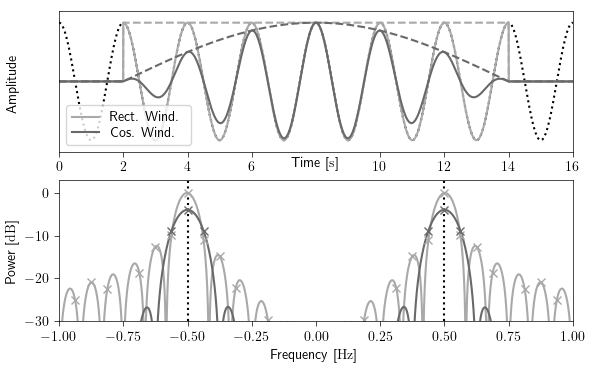

In [32]:
#%matplotlib notebook
#%matplotlib inline

power = lambda a: 10*np.log10(a**2)

dur=16#4*2*np.pi
N=4096
t=np.linspace(0,dur,N, endpoint=True)
dt=t[1]-t[0]
df=1/dur

num_cyc=8 # sine signal with xx cycles in dur
thisf=num_cyc*df 
thisT=1/thisf # period of sine signal
sin_sig=np.cos(thisf*2*np.pi*t)

win_len_cyc=6 # num_cyc/2
win_start=(num_cyc-win_len_cyc)/2*thisT
ind=int(win_start/dt) # index of end of cycle, where window starts
win_len=win_len_cyc*thisT

do_rect=True
do_cos=True

with matplotlib.rc_context(rc=print_context_dict):
    fig,[ax1,ax2]=plt.subplots(2,1)
#     _,[ax3,ax4] =plt.subplots(2,1, figsize=(5.906*2,5.906/1.618*2), sharex=True)
    
    ax1.plot(t,sin_sig, ls='dotted', color='black')
    if do_rect:
        rect_win=np.ones_like(sin_sig)
        rect_win[:ind+1]=0
        rect_win[-ind-1:]=0
        ax1.plot(t,sin_sig*rect_win, label='Rect. Wind.', color='darkgrey')
        ax1.plot(t,rect_win, ls='dashed', color='darkgrey')
    if do_cos:
        cos_win=np.sin(np.pi*(t-ind*dt)/win_len)
        cos_win[:ind+1]=0
        cos_win[-ind-1:]=0
    #     print(win[ind-1:-ind+1])
        ax1.plot(t,cos_win, ls='dashed', color='dimgrey')
        ax1.plot(t,cos_win*sin_sig, label='Cos. Wind.',color='dimgrey')
    
    ax1.set_yticks([])
    ax1.set_ylabel('Amplitude')
    ax1.set_xlabel('Time [\si{\second}]', backgroundcolor="white",labelpad=-12)
    #ax1.xaxis.set_major_locator(plt.MultipleLocator(2*np.pi))
    #ax1.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(0.5)))
    ax1.set_xlim((0,dur))
    ax1.set_ylim((-1.2,1.2))
    
    fftfreq = np.fft.fftfreq(N,dt)
    anafreq=np.linspace(-1,1,N,endpoint=True)

    ax2.axvline(thisf, color='black', ls='dotted')
    ax2.axvline(-thisf, color='black', ls='dotted')
    if do_rect:
        this_omegas=(anafreq-thisf)*2*np.pi
        spect_an=win_len*np.sin(this_omegas*win_len/2)/(this_omegas*win_len/2)*np.exp(-1j*this_omegas*win_len/2)
        spect_an=-1j/this_omegas+1j/this_omegas*np.exp(-1j*this_omegas*win_len)
        spect_an/=win_len
        
        this_omegas=(anafreq+thisf)*2*np.pi
        spect_an2=win_len*np.sin(this_omegas*win_len/2)/(this_omegas*win_len/2)*np.exp(-1j*this_omegas*win_len/2)
        spect_an2=-1j/this_omegas+1j/this_omegas*np.exp(-1j*this_omegas*win_len)
        spect_an2/=win_len
        
        ax2.plot(anafreq,power(np.abs(spect_an+spect_an2)), label='rect', color='darkgrey')
        #ax2.plot(anafreq,power(np.abs(1j*(spect_an+spect_an2))), color='blue')
#         ax3.plot(anafreq,np.abs(spect_an), label='rect', color='darkgrey')
#         ax3.plot(anafreq,np.abs(spect_an2), label='rect', color='black')
#         ax3.plot(anafreq,np.abs(spect_an+spect_an2), label='rect', color='blue')
#         ax4.plot(anafreq,np.angle(spect_an), label='rect', color='darkgrey')
#         ax4.plot(anafreq,np.angle(spect_an2), label='rect', color='black')
#         ax4.plot(anafreq,np.angle(spect_an+spect_an2), label='rect', color='blue')

    if do_cos:
        this_omegas=(anafreq-thisf)*2*np.pi
        spect_an=np.cos(this_omegas*win_len/2)*(win_len/(np.pi-this_omegas*win_len)+win_len/(np.pi+this_omegas*win_len))*np.exp(-1j*this_omegas*win_len/2)
        spect_an/=win_len
        
        this_omegas=(anafreq+thisf)*2*np.pi
        spect_an2=np.cos(this_omegas*win_len/2)*(win_len/(np.pi-this_omegas*win_len)+win_len/(np.pi+this_omegas*win_len))*np.exp(-1j*this_omegas*win_len/2)
        spect_an2/=win_len
        
        ax2.plot(anafreq,power(np.abs(spect_an+spect_an2)), label='cos',color='dimgrey')
    
    for do,fact,label,color in zip([do_rect,do_cos],[rect_win,cos_win],['rect','cos'],['darkgrey','dimgrey']):
        if do:
            fft=np.fft.fft(fact*sin_sig)*dt/win_len*2
            
            ax2.plot(fftfreq,power(np.abs(fft)),ls='none', marker='x', label=label,color=color)
            #ax3.plot(fftfreq,np.abs(fft),ls='none', marker='x', label=label,color=color)
            #ax4.plot(fftfreq,np.angle(fft),ls='none', marker='x', label=label,color=color)
            
#     ax3.set_xlim((-2*thisf,2*thisf))
    ax2.set_xlim((-2*thisf,2*thisf))
    ax2.set_ylim((-30,3))
    ax2.set_ylabel('Power [\si{\decibel}]')
    ax2.set_xlabel('Frequency [\si{\hertz}]')
    ax1.legend()
    fig.subplots_adjust(top=0.970,bottom=0.12,left=0.1, right=0.97,wspace=0.02,hspace=0.2)
    fig.align_ylabels()
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/example_window.pdf')
#     fig.savefig('/ismhome/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/example_window.png')